# Supplement to: Holland et al (2018) *Constraining multiple controls on planktic foraminiferal Mg/Ca* <a id='pagetop'></a>

This supplement contains all code and data required to reproduce the analyses in Holland et al (2018).

## Table of Contents

1. [Data Import](#dataimport)
    1. [Carbon Chemistry](#Cchem)
    2. [Parameter Space](#paramspace)
    3. [Mg/Ca vs. Temperature](#mgca_temp)
    4. [Carbon Chemistry Co-variation](#Cchem_var)
    5. [Potential B Effects](#Beffects)
2. [Uncertainties in Foraminiferal Geochemistry](#uncertainties)
3. [Model Formulation](#modelchoice)
    1. [Individual Effects - Mg/Ca](#isolate_mgca)
    2. [Individual Effects - Partitioning](#isolate_part)
    3. [Model Variables](#modelparams)
    4. [Model Functional Form](#funkyform)
    5. [Interactive Terms](#interactive_terms)
    6. [Final Model Form](#modelform)
4. [Model Fitting](#modelfitting)
    1. [Uncertainties in Temperature Prediction](#temp_uncertainties)
    2. [Sanity Check](#sanity)
5. [Model Comparison](#modelcompare)
6. [Model Fit Uncertainties](#mc_uncertainties)
    1. [Application to Independent Data](#otherdata)
7. [Mg/Ca Sensitivity Analysis](#sensitivity)
    1. [Sensitivity to individual variables](#sens_indiv)
    2. [Relative importance of variables](#sens_rel)
    3. [Uncertainty Propagation to Temperature](#unc_prop)
    4. [Past Seawater Conditions](#past_sw)
8. [Application to PETM](#PETM)
    1. [Adaptation to Multi-Species Calibration](#multi_species)
    2. [Apply to PETM Record](#PETM_app)
    3. [DIC from MG/Ca and $\delta^{18}O$](#DIC_d18O)
9. [Hans G.ruber](#Gruber)
    1. [Import *G. ruber* data](#Gruber_load)
    2. [Examine Parameter Space](#Gruber_paramspace)
    3. [CO3 vs. pH](#Gruber_CO3pH)
    4. [Fit Cultured *G. ruber* Data](#Gruber_fit)
    5. [Fit Sediment Trap *G. ruber* data](#Gruber_sed_fit)
    6. [*G. ruber* fit Residuals](#Gruber_resids)
    7. [Model Comparison](#Gruber_skill)


## Usage Notes

The code in this supplements relies on a number of helper functions, which are stored in the 'mg_funks' module in the same folder.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from mg_funks import load, plot, taylor_diag, csystem, figures, supp_figures
from mg_funks.helpers import weighted_moving_average, isolate_constant_conditions
from cbsyst import Csys
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde

import corner
from tqdm import tqdm

import uncertainties as un

from uncertainties.unumpy import nominal_values as nom
from uncertainties.unumpy import std_devs as err

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 120

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 1. Data Import and Evaluation <a id='dataimport'></a>

In [3]:
raw = load.mg_data('Data/Compiled_Mg_Data.xlsx', 'Orbulina')

# remove data without [Mg] and [Ca]
raw = raw.loc[~raw.loc[:,['[Mg]sw', '[Ca]sw']].isnull().any(1)]
# rename columns
raw.columns = pd.MultiIndex.from_product([['Measured'], raw.columns])

# Remove low-CO3 weirdo, because v. unhappy in culture (see culture logs)
raw = raw.loc[raw.loc[:, ('Measured', 'Sample ID')] != 'kh5']

# Apply offest correction to LA-ICPMS data, to align with Russel et al (2004)
raw.loc[raw.Measured.who == 'This Study', ('Measured', 'Mg/Caf')] *= 1.15

# calculate Mg partitioning
raw.loc[:, ('Measured', 'D_Mg')] = raw.loc[:, ('Measured', 'Mg/Caf')] / raw.loc[:, ('Measured', 'Mg/Casw')]

# approximate Lea Alk data
ind = raw.Measured.who == 'Lea'
raw.loc[ind, ('Measured', 'Alk')] = 2213

In [4]:
# set up legend entries and markers for plots
mdict = {'This Study': 'o',
         'Haynes (subm)': '>',
         'Russell': 'd',
         'Spero': '^',
         'Hönisch': 'v',
         'Allen': 's',
         'Lea': '*'
        }


ldict = {'This Study': 'This Study',
         'Haynes (subm)': 'Haynes et al. (sub.)',
         'Russell': 'Russell et al. (2004)',
         'Spero': 'Spero et al. (2015)',
         'Hönisch': 'Hönisch et al. (2013)',
         'Allen': 'Allen et al. (2016)',
         'Lea': 'Lea et al. (1999)',
        }


<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 1.1 Calculate CarbON Chemistry <a id='Cchem'></a>

The raw data has a variety of pairs of measured carbon system parameters:
- $pH_{TOT}$, TA
- $pH_{NBS}$, TA
- $pH_{NBS}$, DIC

These next functions re-calculate the entire carbon system, using K* values corrected for [Mg] and [Ca] by both PHREEQC and MyAMI. We calculate both because of uncertainties in the accuracy of the methods, and present the mean carbon chemistry calculated by each technique (see manuscript).

**Note:** To calculate the carbon system using PHREEQC in your computer, you'll need a working installation of [phreeqpy](https://www.phreeqpy.com/) and [iPHREEQC](https://wwwbrr.cr.usgs.gov/projects/GWC_coupled/phreeqc/). You'll then need to change the value of the `phreeq_path` variable in the `calc_pitzer_Csys` function below. If you're unsure how to do this, the simplest place to start is the installation instructions on the [phreeqpy](https://www.phreeqpy.com/) website.

In [5]:
raw = csystem.calc_pitzer_Csys(raw, phreeq_path='/usr/local/lib/libiphreeqc.so')
# Note: to run this on your compuer, replace the ''/usr/local/lib/libiphreeqc.so'
# with the location of the libiphreeqc.so file on your computer.

raw = csystem.calc_MyAMI_Csys(raw)

raw = csystem.mean_Csys(raw)

Calculating MyAMI Constants: 100%|██████████| 22/22 [00:03<00:00,  6.22it/s]


In [6]:
#isolate subsets
alldat = raw.copy()

# exclude all data from previous studies in initial analysis.
dat = raw.copy()

# exclude data of Allen, Hönisch and Lea, for reasons discussed in manuscript.
dat = dat.loc[dat.Measured.who != 'Allen', :]
dat = dat.loc[dat.Measured.who != 'Hönisch', :]
dat = dat.loc[dat.Measured.who != 'Lea', :]  # Alkalinity not measured, cleaning problems

# isolate Russell et al (2004) data for comparison
rus = raw.loc[raw.Measured.who == 'Russell']

# isolate data from all other studies, for later comparison
otherdat = raw.copy()
otherdat = otherdat.loc[(otherdat.Measured.who == 'Allen') |
                        (otherdat.Measured.who == 'Hönisch') |
                        (otherdat.Measured.who == 'Lea')]

Text(0, 0.5, 'Mg/Ca$_{O. universa}$')

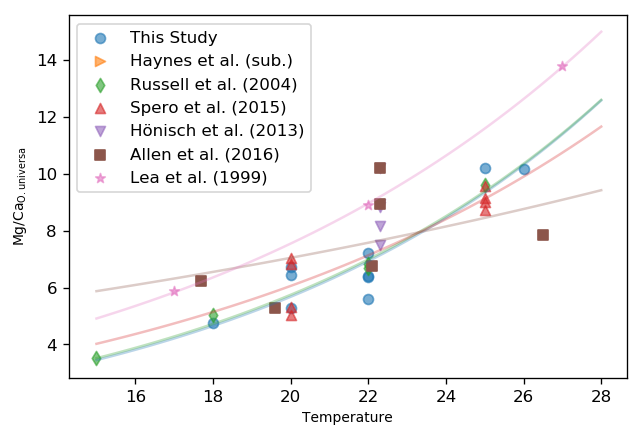

In [7]:
amb = isolate_constant_conditions(raw, DIC=2000, pH=8.1, Mg=50, Ca=10, pH_tolerance=0.2)

def expfn(x, a, b):
    return b * np.exp(x * a)

xn = np.linspace(15, 28)

fig, ax = plt.subplots()
for k, m in mdict.items():
    ind = amb.Measured.who == k
    x = amb.loc[ind, ('Measured', 'Temp')]
    y = amb.loc[ind, ('Measured', 'Mg/Caf')]
    if k == 'Allen':
        alpha = 1
    else:
        alpha=0.6
    pts = ax.scatter(x, y, marker=m, label=ldict[k], alpha=alpha)

    if k in ['Haynes (subm)', 'Hönisch']:
        continue
    p, cov = curve_fit(expfn, x, y)
    
    pred = expfn(xn, *p)
    
    ax.plot(xn, pred, alpha=0.3, color=pts.get_facecolor()[0])
    
ax.legend()

ax.set_xlabel('Temperature')
ax.set_ylabel('Mg/Ca$_{O. universa}$')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 1.2 Data Examination: Parameter Space <a id='paramspace'></a>

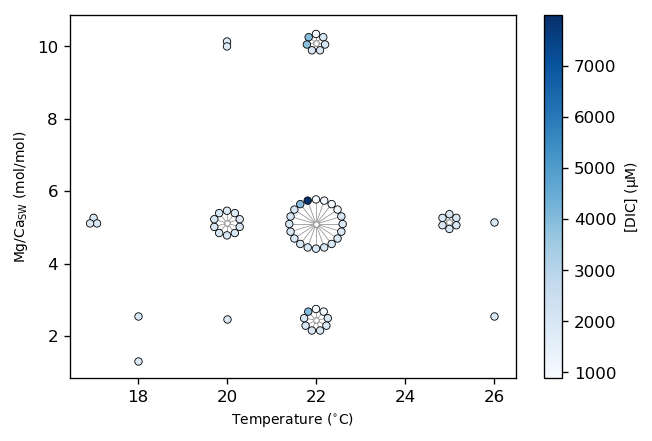

In [8]:
_ = supp_figures.parameter_space(dat)

The data cover a wide range of temperature, seawater Mg/Ca (varying both [Mg] and [Ca] independently), and [DIC]. There are also variations with pH, which will be explored later.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 1.3 Data Examination: Mg/Ca vs. Temperature <a id='mgca_temp'></a>

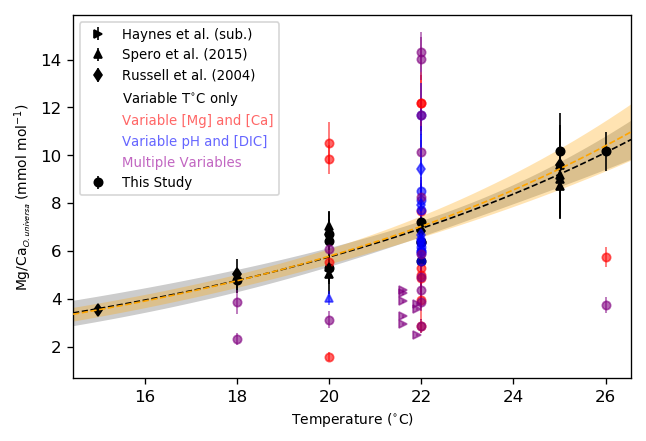

In [9]:
fig, ax = figures.fig1(dat, rus, mdict, ldict)
fig.savefig('Plots/01_Overview.pdf')

The Mg/Ca vs. Temperature trend in our ambient cultures is similar to that observed in previous studies (Russell et al, 2004). However, substantial variance is also driven by changing [Mg], [Ca] and carbon system chemistry, both in isolation and combination.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 1.4 Carbon System <a id='Cchem_var'></a>

As well as exploring the influences of [Mg], [Ca] and Temperature on Mg/Ca, our culture matrix allows us to pick apart the influence of individual aspects of the carbon system, because we have independently varied pH and [CO3]:

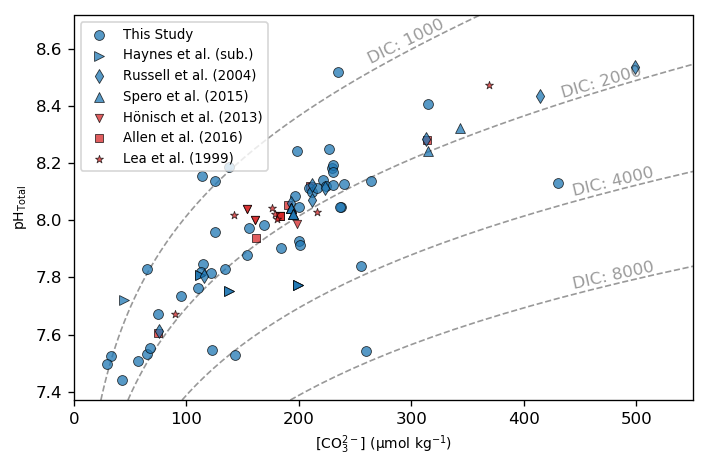

In [10]:
supp_figures.Figure_SX(raw, dat, mdict, ldict)
fig.savefig('Plots/S_pH_CO3.pdf')

All previous studies (red points) have modified pH while keeping DIC relatively constant, leading to the co-variation of pH and [CO3], making the influence of these parameters indistinguishable in the data.

Our new data (blue points) separate pH and [CO3], allowing us to separate the influence of these parameters on the data.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 1.5 Influence of [B] on pH-effects <a id='Beffects'></a>

Is it possible that elevated [B] in culture media mask pH effects by buffering seawater?

To test this, we examine Mg/Ca<sub>O. universa</sub> from our experiments where only pH and [B] vary. If [B] has an influence on the sensitivity of Mg/Ca<sub>O. universa</sub> to pH, we would expect to see systematic differences between the response of high- and low-[B] cultures to pH.

Previous studies have found Mg/Ca<sub>O. universa</sub> to be negatively correlated with pH, particularly at low pH. If elevated [B] acts to supress pH-sensitivity by buffering the local environment, we would expect to observe a reduced sensitivity to pH at high [B].

Text(0, 0.5, 'Mg/Ca ($mmol\\ mol^{-1}$)')

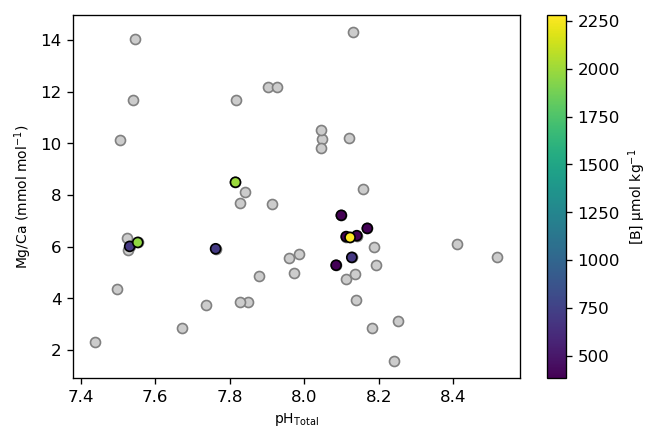

In [11]:
sub = isolate_constant_conditions(dat.loc[dat.Measured.who == 'This Study'], Temp=22, Mg=50, Ca=10, DIC=2000)

fig, ax = plt.subplots(1, 1)

ax.scatter(dat.loc[dat.Measured.who == 'This Study', ('csys_mid', 'pHtot')], 
           dat.loc[dat.Measured.who == 'This Study', ('Measured', 'Mg/Caf')], color=(.8, .8, .8), edgecolor=(.5,.5,.5))
cb = ax.scatter(sub.loc[:, ('csys_mid', 'pHtot')], sub.loc[:, ('Measured', 'Mg/Caf')], c=sub.loc[:, ('Measured', 'B umol/kg')], edgecolor='k')

fig.colorbar(cb, ax=ax, label='[B] $\mu mol\ kg^{-1}$')

ax.set_xlabel('$pH_{Total}$')
ax.set_ylabel('Mg/Ca ($mmol\ mol^{-1}$)')

[B] has no clear systematic effect on Mg/Ca<sub>O. universa</sub>. At low pH, Mg/Ca is idential between [B] of ~700 and ~2000 $\mu mol\ kg^{-1}$. At ambient pH the high [B] (~2200) treatment is indistinguishable from the ambient [B] (~400) treatments. At intermediate pH (~7.8), the high [B] (~2000) treatment has elevated Mg/Ca<sub>O. universa</sub>. This difference is the opposite to what we would expect if B were suppressing a pH effect, as the high-B treatment increases more at lower pH than the intermediate B treatment.

This is consistent with [B] having an insignificant effect on Mg/Ca<sub>O. universa</sub>, and we will include these elevated [B] data in our analyses.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 2. On Uncertainties in Foraminiferal Geochemistry <a id='uncertainties'></a>


Foraminiferal geochemistry exhibits significant inter-individual variability, driven by a variety of largely unconstratined factors including intra-test heterogeneity, biological variability, individual differences in symbiont/respiration micro-environment influence... etc.

A geochemical measurement of a single foraminifera ($g$) shell will deviate from the population mean ($\mu$) a as a function of the variance resulting from inter-individual variability which, assuming it is normally distributed, can be represented as the standard deviation ($\sigma$):

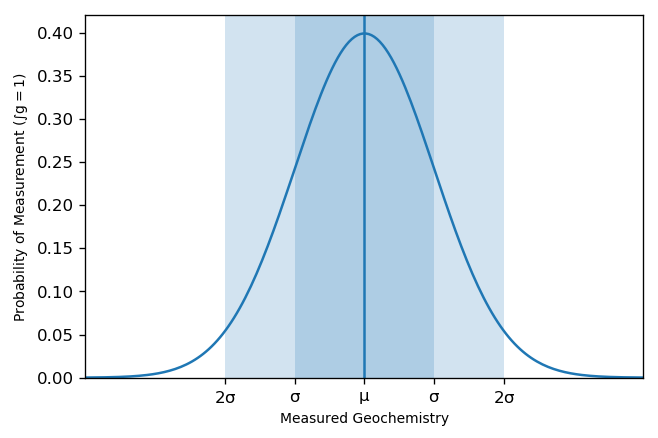

In [12]:
x = np.linspace(1, 9, 200)

pop = 5
sigma = 1

indi = stats.norm(pop, sigma)

fig, ax = plt.subplots(1, 1)
ax.plot(x, indi.pdf(x))
ax.set_xlabel('Measured Geochemistry')
ax.set_ylabel('Probability of Measurement ($\int g = 1$)')
ax.set_ylim(0, 0.42)
ax.set_xlim(1, 9)

ax.set_xticks([pop - 2 * sigma, pop - sigma, pop, pop + sigma, pop + 2 * sigma])
ax.set_xticklabels(['$2\sigma$', '$\sigma$', '$\mu$', '$\sigma$', '$2\sigma$'])

ax.axvline(pop)
ax.axvspan(pop-sigma, pop+sigma, alpha=0.2)
ax.axvspan(pop - sigma * 2, pop + sigma * 2, alpha=0.2)

95.4% of measured values will be within $2\sigma$ of the mean, and 68.3% will be within $\sigma$ of $\mu$.

Conventional analyses foraminiferal geochemistry (excluding individual foraminifera analyses) contain multiple pooled specimens, which should reliably estimate the population when $N$ is sufficiently high, based on the principles of standard error:

$$ SE = \frac{\sigma}{\sqrt{N}} $$

Text(48.995, 0.99, 'Population $\\sigma$')

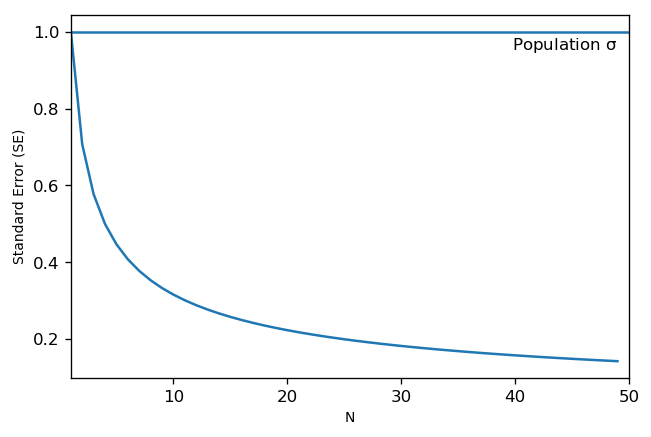

In [13]:
N = np.arange(1, 50)
se = sigma / N**0.5

fig, ax = plt.subplots(1 ,1)

ax.plot(N, se)
ax.set_ylabel('Standard Error (SE)')
ax.set_xlabel('N')
ax.set_xlim(1, 50)

ax.axhline(sigma)
ax.text(N.max() - 0.005, sigma - 0.01, 'Population $\sigma$', va='top', ha='right')

**As long as $N$ is sufficiently high**, pooled analyses offer a good estimate of the population mean.

**For cultured foraminifera, $N$ is rarely high (typically 3-20 shells), so means derived from these measurements may deviate significantly from the true population mean (i.e. SE is high).**

Our combined dataset contains a mixture of pooled solution analyses across a range of $N$, and averages calculated from multiple LA-ICPMS measurements. To compare these data in a consistent way, measurement uncertainties and sample size must be taken into account.

To complicate matters, different authors report substantively different estimates of measurement uncertainty, ranging from the 2SE of multiple LA-ICPMS analyses (directly related to the above plot), to the 'long term standard error' of the analytical technique used. This latter method does not account for $N$ in a pooled analysis, and likely substantially under-estimates uncertainty in the analyses. 

Given this difference, is it possible to meaningfully compare these data?

The simplest solution is to 'reconstruct' an estimated uncertainty for pooled solution measurements, based on knowledge of $N$, and the intra-population variability for *O. universa*.

Our LA-ICPMS data provide a straightforward way to do this, because we have individual analyses of multiple *O. universa* by LA-ICPMS, and can directly measure the intra-population variance.

In [14]:
# isolate our data
esub = dat.loc[dat.loc[:, ('Measured', 'Reference')] == 'This Study', :].Measured
# where N > 10, so we're not biased by low samples size
esub = esub.loc[esub.numberforams > 10]

In [15]:
meas = esub.loc[:, 'Mg/Caf']  # measured Mg/Ca
se = esub.loc[:, 'Mg/Caf 2se'] / 2  # measured uncertainty from multiple individual foraminifera analyses
N = esub.numberforams  # number of forams in average
std = se * N**0.5  # calculate standard deviation

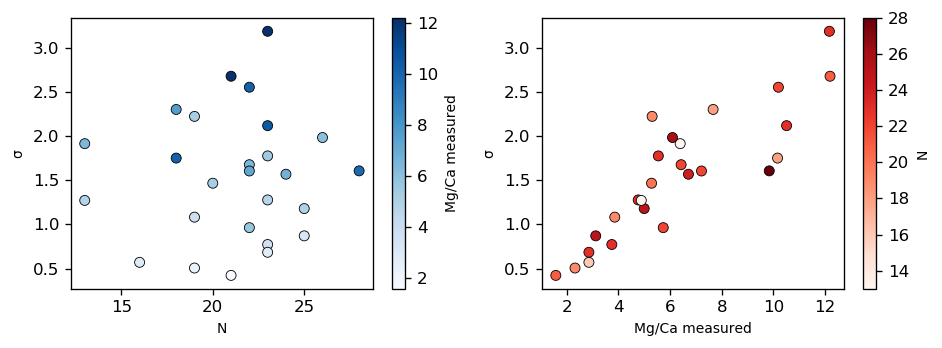

In [16]:
# plot the relationship between N, standard deviation, and Mg/Caforam

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 3])

ma = ax1.scatter(N, std, c=meas, cmap=plt.cm.Blues, lw=0.5, edgecolor='k')
fig.colorbar(ma, label='Mg/Ca measured', ax=ax1)

ax1.set_xlabel('N')
ax1.set_ylabel('$\sigma$')

ma = ax2.scatter(meas, std, c=N, cmap=plt.cm.Reds, lw=0.5, edgecolor='k')
fig.colorbar(ma, label='N', ax=ax2)

ax2.set_xlabel('Mg/Ca measured')
ax2.set_ylabel('$\sigma$')

fig.tight_layout()

We see a strong positive trend between mean Mg/Ca and $\sigma$ with an approximately zero intercept. This suggests that populations with higher Mg/Ca also exhibit more inter-individual variability.

Expressing variance as relative standard deviation ($RSD = \frac{\sigma}{\mu}$) allows us to account for this trend, and estimate a Mg/Ca-dependent population $\sigma$ for each experiment

Text(0.5, 1.0, 'Median RSD: 0.26')

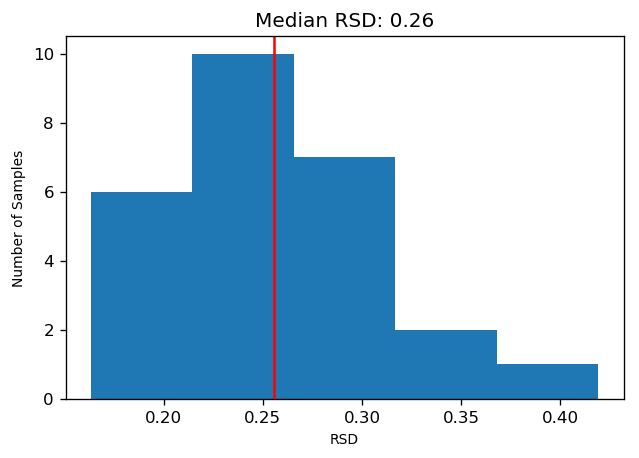

In [17]:
smeas = meas[N > 10]
sstd = std[N > 10]

# calculate rsd
srsd = sstd / smeas

plt.hist(srsd, 5)
plt.axvline(srsd.median(), c='r')

plt.xlabel('RSD')
plt.ylabel('Number of Samples')

plt.title('Median RSD: {:.2f}'.format(srsd.median()))

Population $\sigma$ is best described by an RSD of 0.26

We can use this to estimate population standard deviation from the measured Mg/Ca in all our data points, then calculate SE based on $N$.

In [18]:
ifa_rsd = srsd.median()

# calculate predicted STD and SE for all samples
dat.loc[:, ('Uncertainties', 'calc_STD')] = ifa_rsd * np.sqrt(dat.loc[:, ('Measured', 'Mg/Caf')])
dat.loc[:, ('Uncertainties', 'calc_SE')] = dat.loc[:, ('Uncertainties', 'calc_STD')] / np.sqrt(dat.loc[:, ('Measured', 'numberforams')])

# created a new 'estimated_SE' uncertainty variable from calculated SE
dat.loc[:, ('Uncertainties', 'estimated_SE')] = dat.loc[:, ('Uncertainties', 'calc_SE')]

In [19]:
ifa_rsd

0.2554548157013339

Wherever our estimated SE is greater than the reported uncertainty (e.g. for solution data), we will used the estimated value in its place.

In [20]:
# wherever estimated uncertainty is less than reported uncertainty, replace the estimated value with the reported value.
lessthanmeasured = dat.loc[:, ('Uncertainties', 'estimated_SE')] < (dat.loc[:, ('Measured', 'Mg/Caf 2se')] / 2)
dat.loc[lessthanmeasured, ('Uncertainties', 'estimated_SE')] = (dat.loc[lessthanmeasured, ('Measured', 'Mg/Caf 2se')] / 2)

Finally, we convert the estimated SE to a 95% confidence interval, which is a more conservative estimate of uncertainty.

In [21]:
# calculate 95% CI
dat.loc[:, ('Uncertainties', 'CI95')] = dat.loc[:, ('Uncertainties', 'estimated_SE')] * stats.t.interval(0.95, df=dat.loc[:, ('Measured', 'numberforams')] - 1)[-1]

In [22]:
# do the same for 'otherdat'

# calculate predicted STD and SE for all samples
otherdat.loc[:, ('Uncertainties', 'calc_STD')] = ifa_rsd * np.sqrt(otherdat.loc[:, ('Measured', 'Mg/Caf')])
otherdat.loc[:, ('Uncertainties', 'calc_SE')] = otherdat.loc[:, ('Uncertainties', 'calc_STD')] / np.sqrt(otherdat.loc[:, ('Measured', 'numberforams')])

# created a new 'estimated_SE' uncertainty variable from calculated SE
otherdat.loc[:, ('Uncertainties', 'estimated_SE')] = otherdat.loc[:, ('Uncertainties', 'calc_SE')]

# wherever estimated uncertainty is less than reported uncertainty, replace the estimated value with the reported value.
lessthanmeasured = otherdat.loc[:, ('Uncertainties', 'estimated_SE')] < (otherdat.loc[:, ('Measured', 'Mg/Caf 2se')] / 2)
otherdat.loc[lessthanmeasured, ('Uncertainties', 'estimated_SE')] = (otherdat.loc[lessthanmeasured, ('Measured', 'Mg/Caf 2se')] / 2)

# calculate 95% CI
otherdat.loc[:, ('Uncertainties', 'CI95')] = otherdat.loc[:, ('Uncertainties', 'estimated_SE')] * stats.t.interval(0.95, df=otherdat.loc[:, ('Measured', 'numberforams')] - 1)[-1]

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 3. Model Formulation<a id='modelchoice'></a>

In choosing how to parameterise the model, we consider subsets of the data where only one parameter varies more than 10%.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 3.1 Individual Effects: Mg/Ca <a id='isolate_mgca'></a>

In [23]:
from mg_funks.plot import angle_of_line

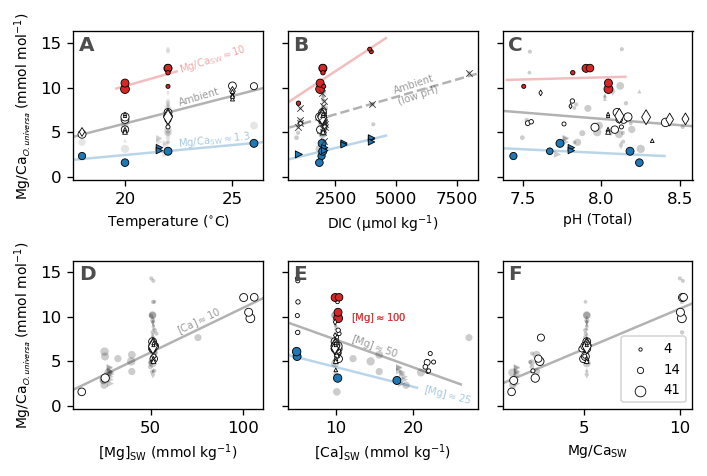

In [24]:
fig, axs = figures.fig2(dat, mdict, ldict)
    
fig.savefig('Plots/02_isolated_parameters_MgCa.pdf')

**Observations:**
- The relationship with temperature appears linear (with a hint of the well-established exponential relationship), and is modulated by Mg/Ca<sub>SW</sub>.
- There is a linear relationship with DIC, which is modulated by Mg/Ca<sub>SW</sub>
- There is no clear relationship with pH.
- There are clear trends with [Ca], which may be the result of the corresponding modification of Mg/Ca<sub>SW</sub>.
-  [Mg] and Mg/Ca exert a dominant influence, and dwarf the other trends. The variance introduced by all other parameters is evident in the scatter of points around the linear relationships in (D) and (F). 

To remove this trend and better highlight the influence of other parameters, we'll look at this in partitioning space.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 3.2 Individual Effects: Partitioning <a id='isolate_part'></a>

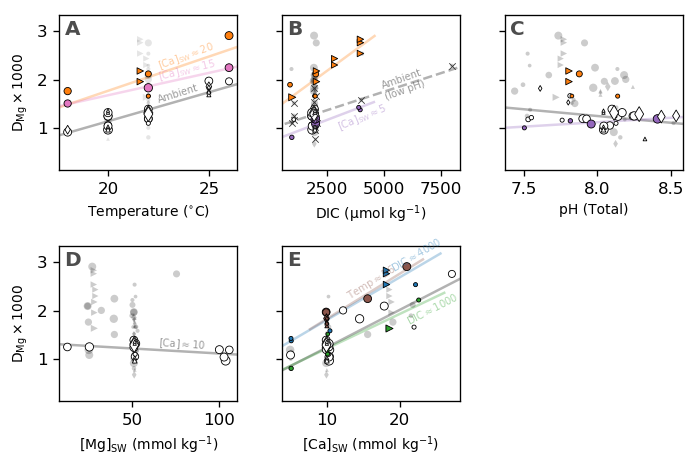

In [25]:
fig, axs = figures.fig3(dat, mdict)
fig.savefig('Plots/03_isolated_parameters_DMg.pdf')

**Observations:**
- Temperature, DIC and [Ca]sw all influence partitioning.
- pH has no obvious *consistent* influence.
- [Mg]sw has a negligible influence on partitioning.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 3.3: Model Variables <a id='modelparams'></a>

Our data allow us to resolve several distinct controls on foraminiferal Mg/Ca.

First, it's clear that Mg/Casw exerts a primary influence on Mg/Caforam. This is intuitive, as variations in Mg/Casw will alter the opportunity for Mg substitution into calcite: all else being equal, we would expect calcite Mg/Ca to increase with solution Mg/Ca, as there are more opportunities for Mg to substitute for Ca. When Mg is a major impurity, it interacts with crystal growth to alter its incorporation (Davis et al 2000, 2004), but we would expect these effects to be negligible in low-Mg hyaline foraminifera, where even 'high' Mg/Ca (~10 mmol mol<sup>-1</sup>) is below the threshold where these effects start to become significant. Therefore, at foraminiferal concentrations we would not expect the solution Mg/Ca to significantly influence Mg partitioning, and it can effectively be considered as setting the 'starting point' of foraminiferal Mg/Ca, which is then modified by other parameters that alter the Mg partitioning.

Our data reveal three significant influences on Mg partitioning - Temperature, DIC, and [Ca]sw. Other carbonate system parameters (pH, CO3) have negligible effects, and while there is a slight negative relationship between [Mg]sw and partitioning, this effect is dwarfed by other parameters.

To capture the trends in our data, our model must therefore include:
- Mg/Casw
- Temperature
- [Ca]sw
- DIC

Mechanistically, it is concievable that DIC and [Ca]sw influence foraminiferal Mg/Ca by altering either aspects of ion transport, or the precipitation rate of the mineral. Temperature may exert a thermodynamic influence over Mg substitution, or alter the kinetics of Mg attachment/detachment at the precipitation surface. In reality, these are not distinct processes, and combinations of different processes likely produced the observed patterns.

- - -
Davis, K. J., Dove, P. M., & De Yoreo, J. J. (2000). The role of Mg2+ as an impurity in calcite growth. Science, 290(5494), 1134-1137.

Davis, K. J., Dove, P. M., Wasylenki, L. E., & De Yoreo, J. J. (2004). Morphological consequences of differential Mg2+ incorporation at structurally distinct steps on calcite. American Mineralogist, 89(5-6), 714-720.
- - -

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 3.4 Model Functional Form <a id='funkyform'></a>

The cannonical foraminiferal Mg/Ca - temperature relationship follows an exponential form:

$$ Mg/Ca_{foram} = B\ e^{A T} $$

In this formulation, the pre-exponent (B) defines the $Mg/Ca_{foram}$ that would be produced at T=0. This is then added to by the exponential temperature term, which adds Mg at a defined rate (A) to the foraminiferal calcite at higher temperatures.

There is no a-priori reason to use an exponential form for this equation. Particularly as the thermodynamic substitution mechanism invoked to explain the Mg/Ca-temperature relationship predicts an asymptotic function. The use of an exponential form is entirely empirical. The concept of an 'initial' $Mg/Ca_{foram}$ that is modified in response to a secondary parameters does, however, provide a useful framework from which to design our model.

For example, our data (and past studies) show that Mg/Casw effectively alters this 'initial' Mg/Ca, and provides the 'initial' Mg/Ca value, with no modification from other parameters:

$$ ^{initial}Mg/Ca_{foram} = f(Mg/Ca_{SW}) $$

When all else is constant, this relationship is slightly convex, with a remarkably similar form to results from inorganic data at low solution Mg/Ca (e.g. Mucci & Morse, 1983, Fig 7):

- - -
Mucci, A., & Morse, J. W. (1983). The incorporation of Mg2+ and Sr2+ into calcite overgrowths: influences of growth rate and solution composition. Geochimica et Cosmochimica Acta, 47(2), 217-233.
- - -

Text(0, 0.5, '$Mg/Ca_{foram}$ (mmol $mol^{-1}$)')

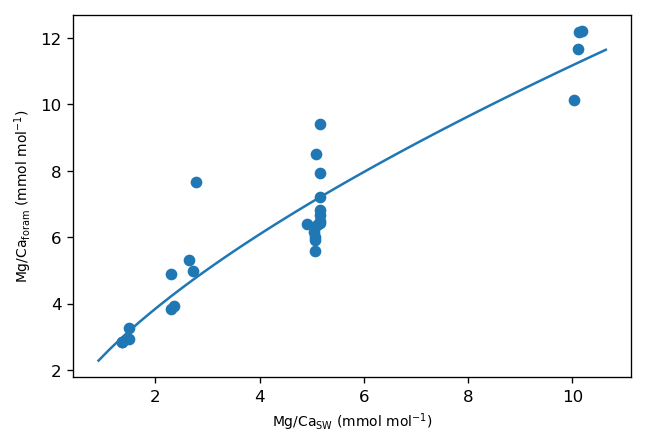

In [26]:
fig, ax = plt.subplots(1, 1)

sub = isolate_constant_conditions(dat, Temp=22, Ca=None, Mg=None, MgCa=None, DIC=2000, tolerance=.05)

ma = ax.scatter(sub.loc[:, ('Measured', 'Mg/Casw')], sub.loc[:, ('Measured', 'Mg/Caf')], 
                label='_')
xn = np.linspace(*ax.get_xlim(), 50)

def mg_fn_pow(mgca, A, B):
    return mgca**A * B

p, cov = curve_fit(mg_fn_pow, sub.loc[:, ('Measured', 'Mg/Casw')], sub.loc[:, ('Measured', 'Mg/Caf')])
ax.plot(xn, mg_fn_pow(xn, *p), label= '$Mg/Ca_{foram}$ =' + ' {:.2f}'.format(p[1]) + '$\\times Mg/Ca_{SW}\ ^{' + '{:.2f}'.format(p[0]) + '}$')

ax.set_xlabel('$Mg/Ca_{SW}$ (mmol $mol^{-1}$)')
ax.set_ylabel('$Mg/Ca_{foram}$ (mmol $mol^{-1}$)')

This relationship is equally well described by a second order polynomial, and a power-law modification of a pre-exponential constant. We opt for the power-law parameterisation, as it has been used by previous studies (Evans et al, 2016), and it allows for a much simpler model parameterisation. Thus, our pre-exponential constant is defined as a function of Mg/Ca<sub>SW</sub>:

$$ ^{initial}Mg/Ca_{foram} = [Mg/Ca_{SW}]^{A}\ B $$

The initial composition defined by seawater Mg/Ca is then modified by parameters that control the partitiong of Mg into the foraminifera:

$$ Mg/Ca_{foram} = [Mg/Ca_{SW}]^{A}\ B \times f([Ca]_{SW}, [DIC]_{SW}, T, ...) $$

From the literature and the data above, temperature appears to be a secondary control on Mg/Ca. 
From past data, there is compelling reason to include temperature as an exponential term, i.e.:

$$ Mg/Ca_{foram} = f(Mg/Ca_{SW})\ e^{f(T)} $$

We must now work out how to parameterise the sensitvity of Mg/Ca to [Ca] and DIC: are they stand-alone partitioning modifiers, which could be include as separate additive linear terms, or are there synergistic effects between the parameters that control partitioning - do they modify the *sensitivity* of Mg partitioning to temperature? Mechanistically, the latter might occurr if [Ca] and [DIC] affect Mg/Ca by altering crystal precipitation rate, which could also be sensitive to temperature.

Let's explore interactivity between the parameters that influence partitioning...


- - -
Evans, D., Brierly, C., Raymo, M. E., Erez, J., Muller, W. 2016. Planktic foraminifera shell chemistry response to seawater chemistry: Pliocene–Pleistocene seawater Mg/Ca, temperature and sea level change. Earth and Planetary Science Letters 438, 139-148
- - -


#### 3.4.1 Partitioning Parameter Interactivity?

First, we'll look for interactions between Temperature and [Ca]sw.

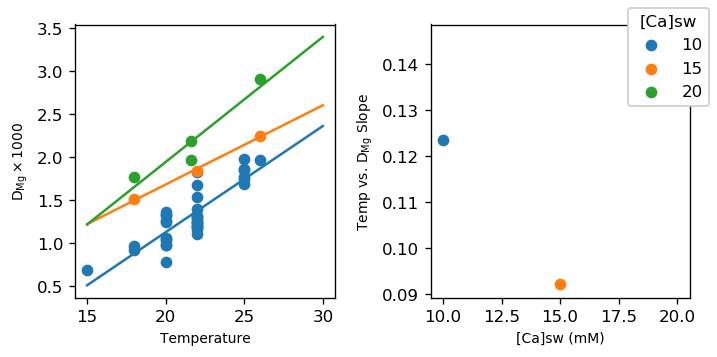

In [27]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=[6, 3])

xn = np.linspace(15, 30, 50)

for ca in [10, 15, 20]:
    sub = isolate_constant_conditions(dat, Ca=ca, DIC=2000, tolerance=0.08)
    ax.scatter(sub.loc[:, ('Measured', 'Temp')], sub.loc[:, ('Measured', 'D_Mg')], label=ca)
    
    p = np.polyfit(sub.Measured.Temp, sub.Measured.D_Mg, 1)
    ax.plot(xn, np.polyval(p, xn))
    
    ax2.scatter(ca, p[0])

ax.set_xlabel('Temperature')
ax.set_ylabel('$D_{Mg} \\times 1000$')
ax2.set_xlabel('[Ca]sw (mM)')
ax2.set_ylabel('Temp vs. $D_{Mg}$ Slope')

fig.legend(title='[Ca]sw', framealpha=1)
fig.tight_layout()

There is a clear relationship between the sensitivity of Mg partitioning to Temperature, and the [Ca]sw. We can quantify this relationship by looking at Mg partitioning as a function of both Temperature and [Ca]sw:

In [28]:
crossplots = {}

0.05779462432333732


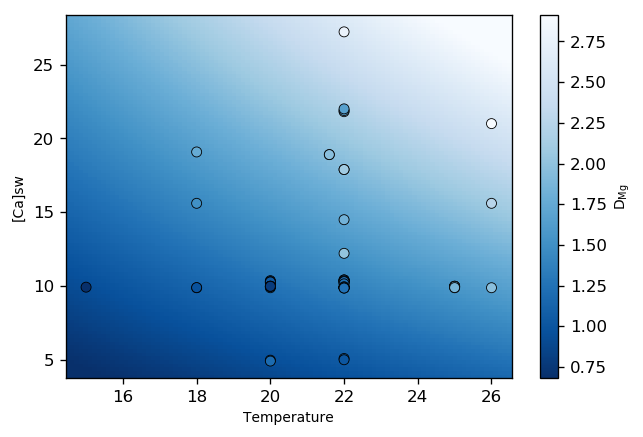

In [29]:
fig, ax = plt.subplots(1, 1)

sub = isolate_constant_conditions(dat, DIC=2000, tolerance=0.08)  # at constant [DIC]
vmin, vmax = sub.loc[:, ('Measured', 'D_Mg')].min(), sub.loc[:, ('Measured', 'D_Mg')].max()
cmap = plt.cm.Blues_r

cm = ax.scatter(sub.loc[:, ('Measured', 'Temp')], sub.loc[:, ('Measured', '[Ca]sw')], c=sub.loc[:, ('Measured', 'D_Mg')],
                edgecolors='k', lw=0.5, vmin=vmin, vmax=vmax, cmap=cmap)
ax.set_xlabel('Temperature')
ax.set_ylabel('[Ca]sw')
fig.colorbar(cm, label='$D_{Mg}$')

# fit the relationship
def ca_fn(x, B, C):
    Temp, Ca = x
    return  (Ca * B + C) * Temp

p, cov = curve_fit(ca_fn, (sub.loc[:, ('Measured', 'Temp')], sub.loc[:, ('Measured', '[Ca]sw')]), sub.loc[:, ('Measured', 'D_Mg')])

x = np.linspace(*ax.get_xlim(), 100)
y = np.linspace(*ax.get_ylim(), 100)
X, Y = np.meshgrid(x, y)

ax.pcolormesh(X, Y, ca_fn((X, Y), *p), zorder=-1,
              vmin=vmin, vmax=vmax, cmap=cmap)

crossplots['T_Ca'] = (X, Y, ca_fn((X, Y), *p), sub.loc[:, ('Measured', 'Temp')], sub.loc[:, ('Measured', '[Ca]sw')], sub.loc[:, ('Measured', 'D_Mg')])

resid = sub.loc[:, ('Measured', 'D_Mg')] - ca_fn((sub.loc[:, ('Measured', 'Temp')], sub.loc[:, ('Measured', '[Ca]sw')]), *p)
print(np.sum(resid**2) / len(resid))

[Ca]sw exerts a clear influence on the sensitivity of Mg paritioning to temperature, and should be included as a modifier of the temperatuer exponential term. The most parsimonious relationship identified above is including [Ca]sw as alinear modifier of temperature sensitivity.

$$ Mg/Ca_{foram} = f(Mg/Ca_{SW})\ e^{(C\ [Ca]_{SW} + D)\ T} $$

How about DIC?

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RankWarning: Polyfit may be poorly conditioned
  if __name__ == '__main__':
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RankWarning: Polyfit may be poorly conditioned
  if __name__ == '__main__':


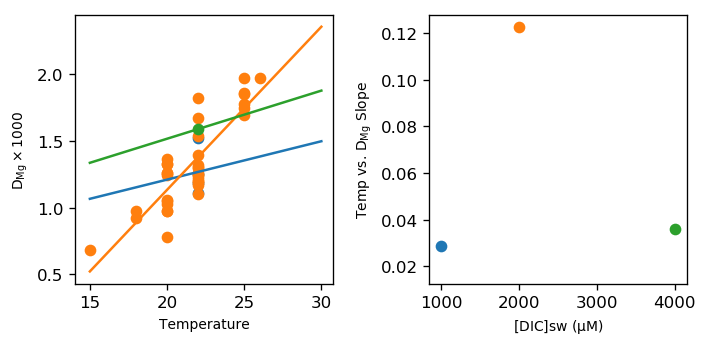

In [30]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=[6, 3])

xn = np.linspace(15, 30, 50)

for dic in [1000, 2000, 4000]:
    sub = isolate_constant_conditions(dat, DIC=dic, Ca=10, tolerance=0.1)
    ax.scatter(sub.loc[:, ('Measured', 'Temp')], sub.loc[:, ('Measured', 'D_Mg')], label=ca)
    
    p = np.polyfit(sub.Measured.Temp, sub.Measured.D_Mg, 1)
    ax.plot(xn, np.polyval(p, xn))
    
    ax2.scatter(dic, p[0])

ax.set_xlabel('Temperature')
ax.set_ylabel('$D_{Mg} \\times 1000$')
ax2.set_xlabel('[DIC]sw ($\mu$M)')
ax2.set_ylabel('Temp vs. $D_{Mg}$ Slope')

# fig.legend(title='[Ca]sw', framealpha=1)
fig.tight_layout()

There are too few temperature points to adequately constrain the influence of discrete DIC treatments on Mg temperature sensitivity. It may, however, be possible to consider continuous DIC variability:

0.04382869615024029


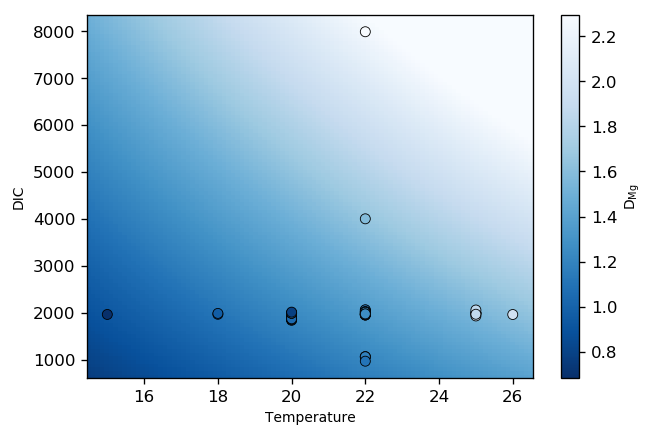

In [31]:
fig, ax = plt.subplots(1, 1)

sub = isolate_constant_conditions(dat, Ca=10, tolerance=0.08)  # at constant [Ca]
vmin, vmax = sub.loc[:, ('Measured', 'D_Mg')].min(), sub.loc[:, ('Measured', 'D_Mg')].max()
cmap = plt.cm.Blues_r

cm = ax.scatter(sub.loc[:, ('Measured', 'Temp')], sub.loc[:, ('csys_mid', 'DIC')], c=sub.loc[:, ('Measured', 'D_Mg')],
                edgecolors='k', lw=0.5, vmin=vmin, vmax=vmax, cmap=cmap)
ax.set_xlabel('Temperature')
ax.set_ylabel('DIC')
fig.colorbar(cm, label='$D_{Mg}$')

# fit the relationship
def dic_fn(x, B, C):
    Temp, DIC = x
    return  (DIC * B + C) * Temp

p, cov = curve_fit(dic_fn, (sub.loc[:, ('Measured', 'Temp')], sub.loc[:, ('csys_mid', 'DIC')]), sub.loc[:, ('Measured', 'D_Mg')])

x = np.linspace(*ax.get_xlim(), 100)
y = np.linspace(*ax.get_ylim(), 100)
X, Y = np.meshgrid(x, y)

ax.pcolormesh(X, Y, dic_fn((X, Y), *p), zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap)

crossplots['T_DIC'] = (X, Y, dic_fn((X, Y), *p), sub.loc[:, ('Measured', 'Temp')], sub.loc[:, ('csys_mid', 'DIC')], sub.loc[:, ('Measured', 'D_Mg')])

resid = sub.loc[:, ('Measured', 'D_Mg')] - ca_fn((sub.loc[:, ('Measured', 'Temp')], sub.loc[:, ('csys_mid', 'DIC')]), *p)
print(np.sum(resid**2) / len(resid))

The relationship here is less well defined, because we are missing the extremes (i.e. corners) of the parameter space, however given that the influence of DIC is likely to be mechanistically similar to [Ca]sw in altering crystal precipitation rate, we think it logical to include it alongside [Ca]sw as a modifier of the temperature sensitivity coefficient:

$$ Mg/Ca_{foram} = f(Mg/Ca_{SW})\ e^{(C_1\ [Ca]_{SW} + C_2\ [DIC]_{SW} + D)\ T} $$

This implies that the sensitivity of Mg partitioning to temperature (the exponential temperature coefficient) will be sensitive to both [Ca] and [DIC]:

But why should DIC and Ca vary additively? Why not multiplicitavely?

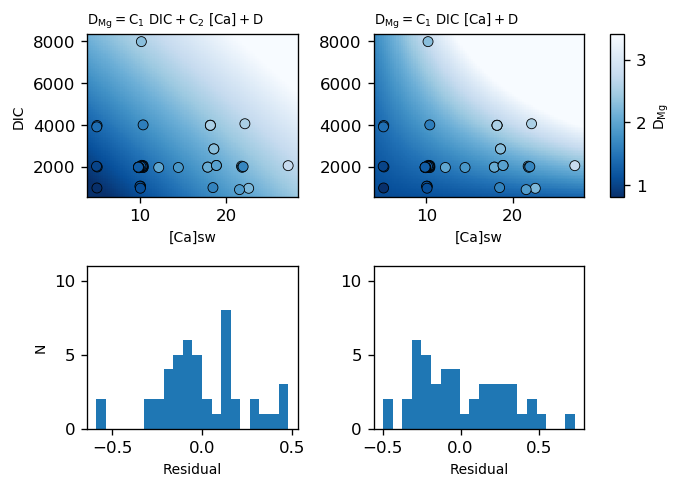

In [32]:
_ , _, crossplots = supp_figures.add_vs_mult(dat, crossplots)

The additive formulation has a larger number of residual points closer to zero (bottom left) than the multiplicative one (bottom right). Although statistically this difference may not be significant...

Functionally, the additive form allows different sensitivies to DIC and [Ca], whereas the multiplicative form implies a gross sensitvity to seawater DIC $\times$ [Ca].

Mechanistically, it is more plausible that foraminifera have separate physiological controls over [Ca] and DIC, so we will use the additive formulation.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 3.5 Interactive Sensitivity Terms <a id='interactive_terms'></a>

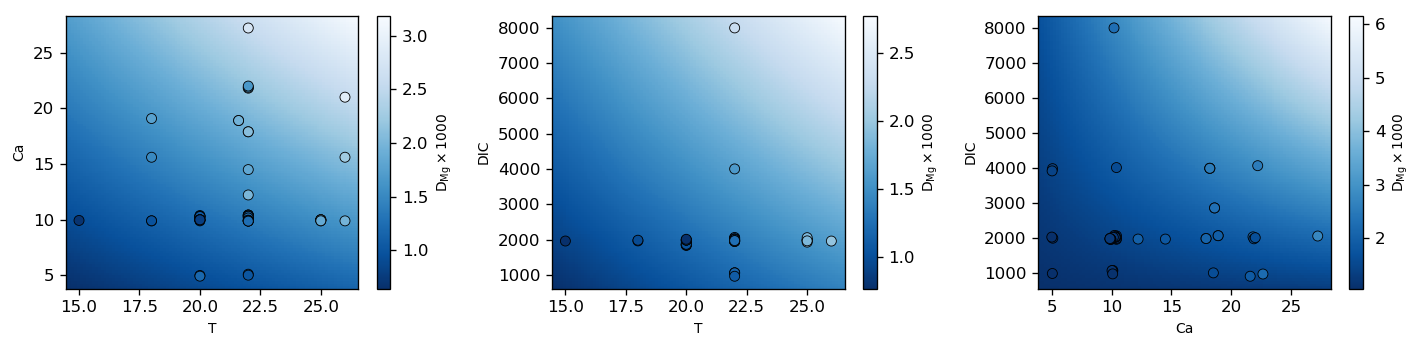

In [33]:
fig, axs = plt.subplots(1, 3, figsize=[12, 3])
abc = 'ABC'

for i, key in enumerate(crossplots.keys()):
    ax = axs[i]
    lab = abc[i]
    x, y, z, dx, dy, dz = crossplots[key]
    vmin = z.min()
    vmax = z.max()
    
    cm = ax.pcolormesh(x, y, z, cmap=plt.cm.Blues_r, vmin=vmin, vmax=vmax)
    ax.scatter(dx, dy, c=dz, cmap=plt.cm.Blues_r, lw=0.5, edgecolor='k', vmin=vmin, vmax=vmax)
    
    ax.set_xlabel(key.split('_')[0])
    ax.set_ylabel(key.split('_')[1])
    
    fig.colorbar(cm, ax=ax, label='$D_{Mg} \\times 1000$')

fig.tight_layout()

fig.savefig('Plots/S_Ca_DIC_T_interaction.pdf')
fig.savefig('Plots/S_Ca_DIC_T_interaction.png', dpi=250)

The functional forms chosen in the exponential term of our model do a reasonable job of predicting the interactive effects of Temperature, [Ca] and DIC on Mg/Ca.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 3.6 Final Model Form <a id='modelform'></a>

The final form of our model is:

$$ Mg/Ca_{foram} = [Mg/Ca_{SW}]^A\ B\ e^{(C_1\ [Ca]_{SW} + C_2\ [DIC]_{SW} + D)\ T} $$

And, consequently:

$$
\begin{align}
T &= \frac{ln\left(\frac{Mg/Ca_{foram}}{[Mg/Ca_{SW}]^A\ B}\right)}{C_1\ [Ca]_{SW}\ + C_2\ [DIC]_{SW} + D} \\
[DIC]_{SW} &= \frac{1}{C_1\ C_2\ [Ca]_{SW}} \left(\frac{ln\left(\frac{Mg/Ca_{foram}}{[Mg/Ca_{SW}]^A\ B}\right)}{T} - D\right) \\
[Ca]_{SW} &= \frac{1}{C_1\ C_2\ [DIC]_{SW}} \left(\frac{ln\left(\frac{Mg/Ca_{foram}}{[Mg/Ca_{SW}]^A\ B}\right)}{T} - D\right) \\
Mg/Ca_{SW} &= \left(\frac{Mg/Ca_{foram}}{B\ e^{(C_1\ [Ca]_{SW}\ + C_2\ [DIC]_{SW} + D)\ T}}\right)^{1/A}
\end{align}
$$

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 4. Model Fitting<a id='modelfitting'></a>

In [34]:
def mgca_fn(x, A, B, C1, C2, D):
    MgCa, Ca, C, T = x
    return MgCa**A * B * np.exp((C1 * Ca + C2 * C + D) * T)

def mgca_fn_u(x, A, B, C1, C2, D):
    MgCa, Ca, C, T = x
    return MgCa**A * B * un.unumpy.exp((C1 * Ca + C2 * C + D) * T)

# package data for fitting
x = (dat.loc[:, ('Measured', 'Mg/Casw')],  # molar ratio (unitless)
     dat.loc[:, ('Measured', '[Ca]sw')] * 1e-3,  # molar
     dat.loc[:, ('csys_mid', 'DIC')] * 1e-6,  # molar
     dat.loc[:, ('Measured', 'Temp')])  # celcius

# weight fit as 1/N - gives more power to high sample sizes
sigma = 1/(dat.loc[:, ('Measured', 'numberforams')])**0.5

# fit model
p, cov = curve_fit(mgca_fn, x, dat.loc[:, ('Measured', 'Mg/Caf')], 
                   sigma=sigma)

In [35]:
# optimal parameters
p

pe = un.correlated_values(p, cov)

To assess the goodness of fit of the model, we compare measured vs. predicted Mg/Ca.

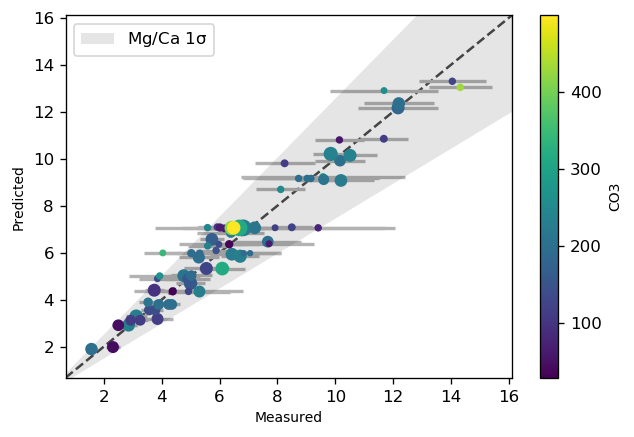

In [36]:
fig, ax = plot.compare(obs=dat.loc[:, ('Measured', 'Mg/Caf')], 
                       pred=mgca_fn(x, *p),
                       errs=dat.loc[:, ('Uncertainties', 'CI95')],
                       c=dat.loc[:, ('csys_mid', 'CO3')],
                       clab='CO3', s=2 * dat.loc[:, ('Measured', 'numberforams')])

lim = np.array(ax.get_xlim())
ax.fill_between(lim, lim + lim * ifa_rsd, lim - lim * ifa_rsd, alpha=0.1, color='k', lw=0, zorder=-1, label='Mg/Ca $1\sigma$')
ax.legend()

And to assess whether there are any systematic patterns in the residuals (implying unaccounted for effects in the model), we plot the residual (measued - predicted) Mg/Ca as a funciton of all measured variabiles.

In [37]:
from scipy import stats

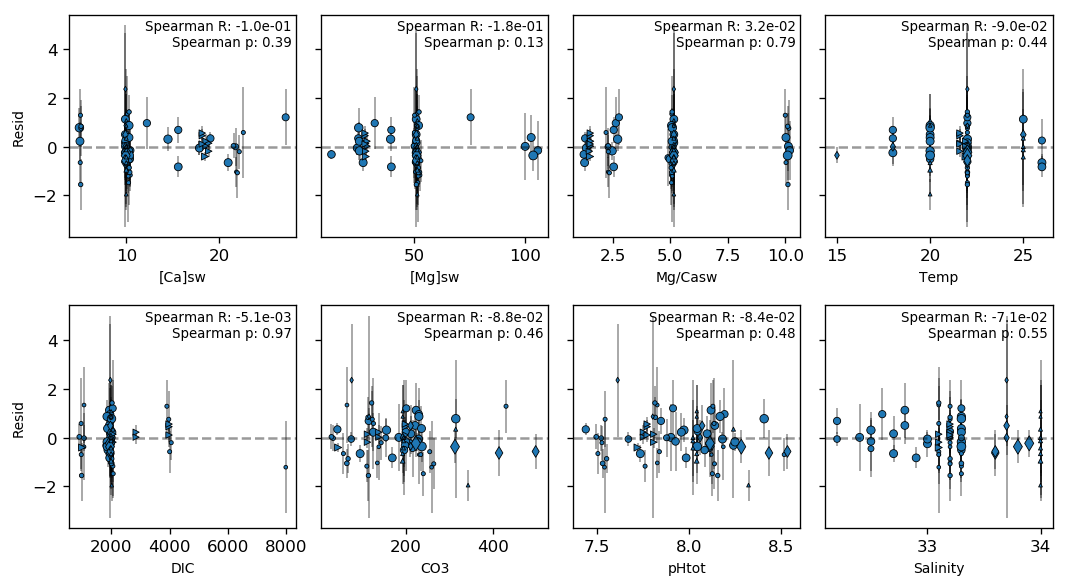

In [38]:
vari = (('Measured', '[Ca]sw'),
        ('Measured', '[Mg]sw'),
        ('Measured', 'Mg/Casw'),
        ('Measured', 'Temp'),
        ('csys_mid', 'DIC'),
        ('csys_mid', 'CO3'),
        ('csys_mid', 'pHtot'),
        ('Measured', 'Salinity'))

resid = dat.loc[:, ('Measured', 'Mg/Caf')] - mgca_fn(x, *p)
# resid_e = dat.loc[:, ('Measured', 'Mg/Caf 2se')]
resid_e = dat.loc[:, ('Uncertainties', 'CI95')]

fig, axs = plt.subplots(2, 4, figsize=(9, 5), sharey=True)

s = dat.loc[:, ('Measured', 'numberforams')]

for v, ax in zip(vari, axs.flatten()):
    
    for k, m in mdict.items():
        
        ind = dat.Measured.who == k
        
        dep = dat.loc[ind, v]
        r = resid.loc[ind]
        re = resid_e.loc[ind]
        si = s.loc[ind]
        
        ax.scatter(dep, r, zorder=2, marker=m, c='C0', edgecolor='k', lw=0.5, s=si)
        ax.errorbar(dep, r, re, lw=0, elinewidth=1, zorder=-2, c=(0,0,0,0.4))
    
    R, sp = stats.spearmanr(dat.loc[:, v], resid)
    if sp < 0.01:
        spt = '< 0.01'
    else:
        spt = '{:.2f}'.format(sp)
    stat_text = 'Spearman R: {:.1e}\nSpearman p: {}'.format(R, spt)
    ax.text(.98, .98, stat_text, va='top', ha='right', transform=ax.transAxes, fontsize=8)
    
    ax.set_xlabel(v[-1])
    if ax.is_first_col():
        ax.set_ylabel('Resid')
        
    ax.axhline(0, ls='dashed', color=(0,0,0,0.4))
    
fig.tight_layout()

There are no clear trends, suggesting that our model adequately captures all effects in our data.

Double check for pH trends, given that they have been see in previous studies:

In [39]:
sub = isolate_constant_conditions(dat, Temp=20, DIC=2000, Ca=10.2, Mg=50, tolerance=0.1)

In [40]:
r = resid[np.array([i in sub.index for i in dat.index])]
re = resid_e[np.array([i in sub.index for i in dat.index])]

This Study SpearmanrResult(correlation=0.3636363636363637, pvalue=0.2452650007307772)
Russell SpearmanrResult(correlation=-0.9642857142857145, pvalue=0.0004541491691941689)
Spero SpearmanrResult(correlation=-0.7071067811865475, pvalue=0.18169011381620928)
all SpearmanrResult(correlation=-0.1250547630182869, pvalue=0.5604124251105127)


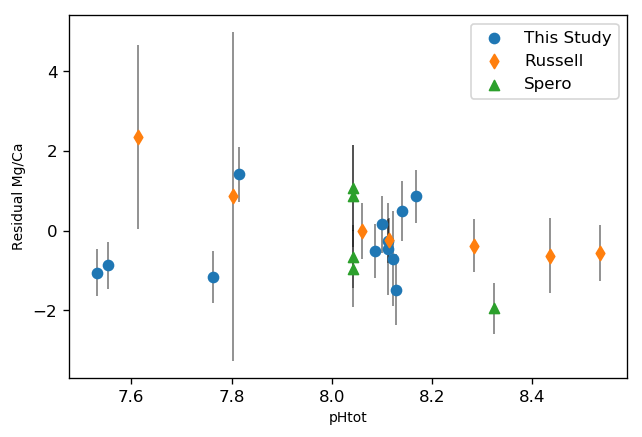

In [41]:
for k, m in mdict.items():
    ind = sub.Measured.who == k
    if any(ind):
        plt.scatter(sub.loc[ind, ('csys_mid', 'pHtot')], r[ind], marker=m, label=k)
        plt.errorbar(sub.loc[ind, ('csys_mid', 'pHtot')], r[ind], re[ind], lw=0, elinewidth=1, color=(0,0,0,0.5), zorder=-2)
        print(k, stats.spearmanr(sub.loc[ind, ('csys_mid', 'pHtot')], r[ind]))
        
print('all', stats.spearmanr(sub.loc[:, ('csys_mid', 'pHtot')], r))
    
plt.xlabel('pHtot')
plt.ylabel('Residual Mg/Ca')
plt.legend()

In [42]:
stats.spearmanr(sub.loc[:, ('csys_mid', 'pHtot')], r)

SpearmanrResult(correlation=-0.1250547630182869, pvalue=0.5604124251105127)

No significant trend with pH.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 4.1 Uncertainty in Temperature Prediction <a id='temp_uncertainties'></a>

How do the uncertainties in our model propagate to temperature predictions?

In [43]:
# prediction function
def T_fn(x, A, B, C1, C2, D):
    MgCaf, MgCasw, DIC, Ca = x
    C = (C1 * Ca + C2 * DIC + D)
    return np.log(MgCaf / (MgCasw**A * B)) / C

def T_fn_u(x, A, B, C1, C2, D):
    MgCaf, MgCasw, DIC, Ca = x
    C = (C1 * Ca + C2 * DIC + D)
    return un.unumpy.log(MgCaf / (MgCasw**A * B)) / C

# package data for fitting
xt = (dat.loc[:, ('Measured', 'Mg/Caf')],  # mmol $mol^{-1}$
      dat.loc[:, ('Measured', 'Mg/Casw')],  # molar ratio (unitless)
      dat.loc[:, ('csys_mid', 'DIC')] * 1e-6,  # molar
      dat.loc[:, ('Measured', '[Ca]sw')] * 1e-3)  # molar

In [44]:
pred_T = T_fn(xt, *p)

upper_T = T_fn((dat.loc[:, ('Measured', 'Mg/Caf')] + dat.loc[:, ('Uncertainties', 'CI95')], *xt[1:]), *p)
lower_T = T_fn((dat.loc[:, ('Measured', 'Mg/Caf')] - dat.loc[:, ('Uncertainties', 'CI95')], *xt[1:]), *p)

In [45]:
mgca_s = np.linspace(2, 15)
dic = 2000e-6
ca = 10.2e-3
mgcasw = 5.1

med_ifa = T_fn((mgca_s, mgcasw, dic, ca), *p)
upper_ifa = T_fn((mgca_s + mgca_s * ifa_rsd, mgcasw, dic, ca), *p)
lower_ifa = T_fn((mgca_s - mgca_s * ifa_rsd, mgcasw, dic, ca), *p)

Text(0, 0.5, 'Predicted T')

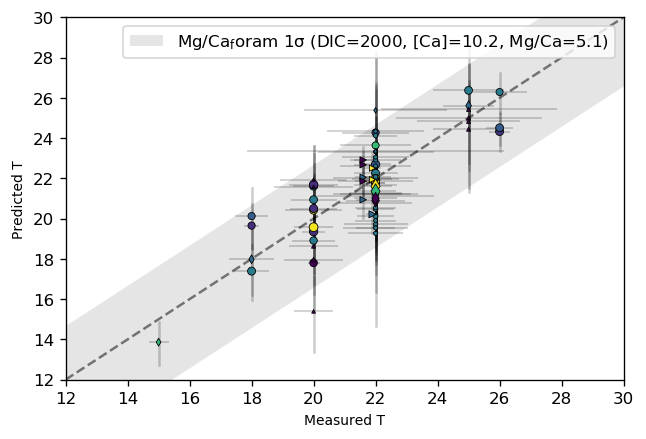

In [46]:
fig, ax = plt.subplots(1, 1)

s = dat.loc[:, ('Measured', 'numberforams')]

for k, m in mdict.items():
    ind = dat.Measured.who == k
    
    cvar = dat.loc[ind, ('Measured', '[Mg]sw')]
    dep = dat.loc[ind, ('Measured', 'Temp')]
    pr = pred_T[ind]
    si = s.loc[ind]

    ax.scatter(dep, pr, zorder=2, marker=m, edgecolor='k', lw=0.5, s=si, c=cvar)
    
    ax.errorbar(dep, pr, xerr=dat.loc[ind, ('Uncertainties', 'CI95')], color=(0,0,0,0.2), lw=0, elinewidth=1, zorder=-9)
    
    for xi, lo, hi in zip(dep, lower_T[ind], upper_T[ind]):
        ax.plot([xi, xi], [lo, hi], c=(0,0,0,0.2), zorder=-10)
    
ax.fill_between(med_ifa, lower_ifa, upper_ifa, color=(0,0,0,0.1), lw=0, label='$Mg/Ca_foram\ 1\sigma$ (DIC=2000, [Ca]=10.2, Mg/Ca=5.1)')

lim = (12, 30)
ax.set_xlim(lim)
ax.set_ylim(lim)

ax.plot(ax.get_xlim(), ax.get_xlim(), ls='dashed', c=(0,0,0,0.5), zorder=-1)

ax.legend()

ax.set_xlabel('Measured T')
ax.set_ylabel('Predicted T')

This plot shows measured vs. predicted temperature. There is considerable scatter around the 1:1 line, but this scatter is within the 1 standard deviation error envelope for individual analyses - we would expect considerable scatter around this line, given the small N in many of our samples.

Error bars in x and y are the 95% confidence limit of the measurement and prediction, respectively

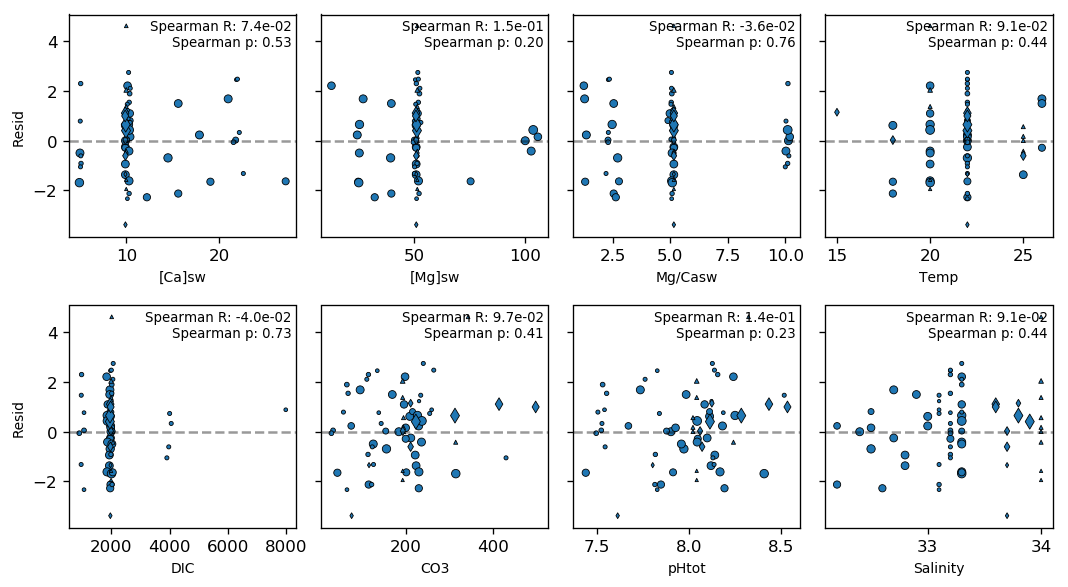

In [47]:
vari = (('Measured', '[Ca]sw'),
        ('Measured', '[Mg]sw'),
        ('Measured', 'Mg/Casw'),
        ('Measured', 'Temp'),
        ('csys_mid', 'DIC'),
        ('csys_mid', 'CO3'),
        ('csys_mid', 'pHtot'),
        ('Measured', 'Salinity'))

resid = dat.loc[:, ('Measured', 'Temp')] - pred_T

fig, axs = plt.subplots(2, 4, figsize=(9, 5), sharey=True)

s = dat.loc[:, ('Measured', 'numberforams')]

for v, ax in zip(vari, axs.flatten()):
    
    for k in ['This Study', 'Spero', 'Russell']:
        m = mdict[k]
        
        ind = dat.Measured.who == k
        
        dep = dat.loc[ind, v]
        r = resid.loc[ind]
        si = s.loc[ind]
        
        ax.scatter(dep, r, zorder=2, marker=m, c='C0', edgecolor='k', lw=0.5, s=si)
    
    R, sp = stats.spearmanr(dat.loc[:, v], resid)
    if sp < 0.01:
        spt = '< 0.01'
    else:
        spt = '{:.2f}'.format(sp)
    stat_text = 'Spearman R: {:.1e}\nSpearman p: {}'.format(R, spt)
    ax.text(.98, .98, stat_text, va='top', ha='right', transform=ax.transAxes, fontsize=8)
    
    ax.set_xlabel(v[-1])
    if ax.is_first_col():
        ax.set_ylabel('Resid')
        
    ax.axhline(0, ls='dashed', color=(0,0,0,0.4))
    
fig.tight_layout()

There are no clear trends in residual (measured - predicted) temperature with any measured variable.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 4.2 Sanity-Check: Can the model reproduce the temperature relationship observed at ambient conditions?<a id='sanity'></a>

Text(0, 0.5, 'Mg/Ca$_{\\it{O. universa}}$ (mmol mol$^{-1}$)')

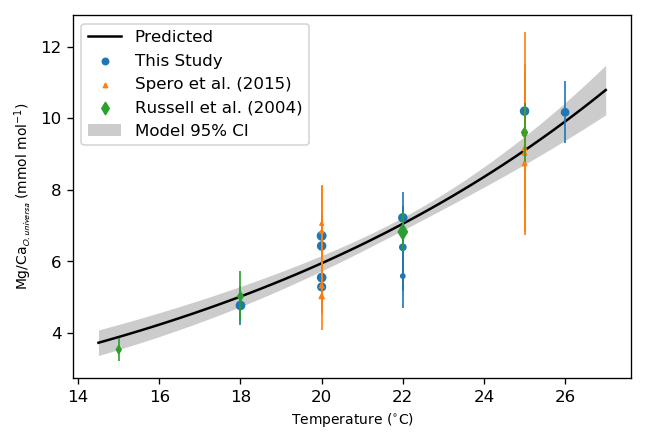

In [48]:
rsub = isolate_constant_conditions(dat, pH=8.05, DIC=2000, MgCa=5)

for who in rsub.Measured.who.unique():
    ind = rsub.Measured.who == who
    plt.scatter(rsub.loc[ind, ('Measured', 'Temp')], rsub.loc[ind, ('Measured', 'Mg/Caf')], 
                label=ldict[who], marker=mdict[who], s=rsub.loc[ind, ('Measured', 'numberforams')])
    plt.errorbar(rsub.loc[ind, ('Measured', 'Temp')], rsub.loc[ind, ('Measured', 'Mg/Caf')], 
                 rsub.loc[ind, ('Uncertainties', 'CI95')], lw=0, elinewidth=1, label='_')

# package data for prediction
tn = np.linspace(14.5, 27, 50)
rx = (5.16,  # molar ratio (unitless)
      rsub.loc[:, ('Measured', '[Ca]sw')].mean() * 1e-3,  # molar
      rsub.loc[:, ('csys_mid', 'DIC')].mean() * 1e-6,  # molar
      tn)  # celcius

pred = mgca_fn_u(rx, *pe)
plt.plot(tn, nom(pred), label='Predicted', c='k', zorder=-1)
# sd = ifa_rsd * pred
sd = err(pred) * 1.96
plt.fill_between(tn, nom(pred)-sd, nom(pred)+sd, color='k', alpha=0.2, label='Model 95% CI', zorder=-1, lw=0)

plt.legend()

plt.xlabel('Temperature ($^{\circ}$C)')
plt.ylabel('Mg/Ca$_{\it{O. universa}}$ (mmol mol$^{-1}$)')

Yes! The model predicts all observed Mg/Ca data well at ambient conditions.

In [49]:
dat.loc[:, ('model', 'prediction')] = mgca_fn(x, *p)
dat.loc[:, ('model', 'residual')] = dat.loc[:, ('Measured', 'Mg/Caf')] - dat.loc[:, ('model', 'prediction')]

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 5. Model Comparison<a id='modelcompare'></a>

To test the skill of this model, we will compare it to other previously proposed methods useing a Taylor Diagram.

We will consider 4 possible models:

1) The 'traditional' exponential relationship.
$$ Mg/Ca_{foram} = B\ e^{A\ T}$$
2) Evans and Mueller (2012) power-law formulation.
$$ Mg/Ca_{foram} = \frac{Mg/Ca_{SW}^{t=t}\ ^H}{Mg/Ca_{SW}^{t=0}\ ^H} B\ e^{A\ T}$$
3) Evans et al (2015) polynomial formulation
$$ Mg/Ca_{foram} = \frac{C\ Mg/Ca_{SW}^{t=t}\ ^2 + D\ Mg/Ca_{SW}^{t=t}}{C\ Mg/Ca_{SW}^{t=0}\ ^2 + D\ Mg/Ca_{SW}^{t=0}} B\ e^{A\ T}$$
4) Our model.
$$ Mg/Ca_{foram} = [Mg/Ca_{SW}]^A\ B\ e^{(C_1\ [Ca]_{SW}\ + C_2\ [DIC]_{SW} + D)\ T} $$

In [50]:
# model formulations

def exponential(temp, A, B):
    return A * np.exp(temp * B)

def evans2012(x, A, B, H):
    temp, mgca_t = x
    mgca_0 = 5.17
    return B * (mgca_t**H / mgca_0**H) * np.exp(A * temp)
                
def evans2015(x, A, B, C, D):
    temp, mgca_t = x
    mgca_0 = 5.17
    return B * np.exp(A * temp) * (C * mgca_t**2 + D * mgca_t) / (C * mgca_0**2 + D * mgca_0)

In [51]:
# fit different models

sigma = dat.loc[:, ('Uncertainties', 'estimated_SE')]

# exponential
exp_p, _ = curve_fit(exponential, dat.loc[:, ('Measured', 'Temp')], 
                     dat.loc[:, ('Measured', 'Mg/Caf')], sigma=sigma)
exp_pred = exponential(dat.loc[:, ('Measured', 'Temp')], *exp_p)

# Evans 2012
e2012_p, e2012_cov = curve_fit(evans2012, (dat.loc[:, ('Measured', 'Temp')], dat.loc[:, ('Measured', 'Mg/Casw')]),
                               dat.loc[:, ('Measured', 'Mg/Caf')], sigma=sigma)
e2012_params = un.correlated_values(e2012_p, e2012_cov)
e2012_pred = evans2012((dat.loc[:, ('Measured', 'Temp')], dat.loc[:, ('Measured', 'Mg/Casw')]), *e2012_p)

# Evans 2015
e2015_p, e2015_cov = curve_fit(evans2015, (dat.loc[:, ('Measured', 'Temp')], dat.loc[:, ('Measured', 'Mg/Casw')]),
                               dat.loc[:, ('Measured', 'Mg/Caf')], sigma=sigma)
e2015_params = un.correlated_values(e2015_p, e2015_cov)
e2015_pred = evans2015((dat.loc[:, ('Measured', 'Temp')], dat.loc[:, ('Measured', 'Mg/Casw')]), *e2015_p)

# Our model
pred = mgca_fn(x, *p)

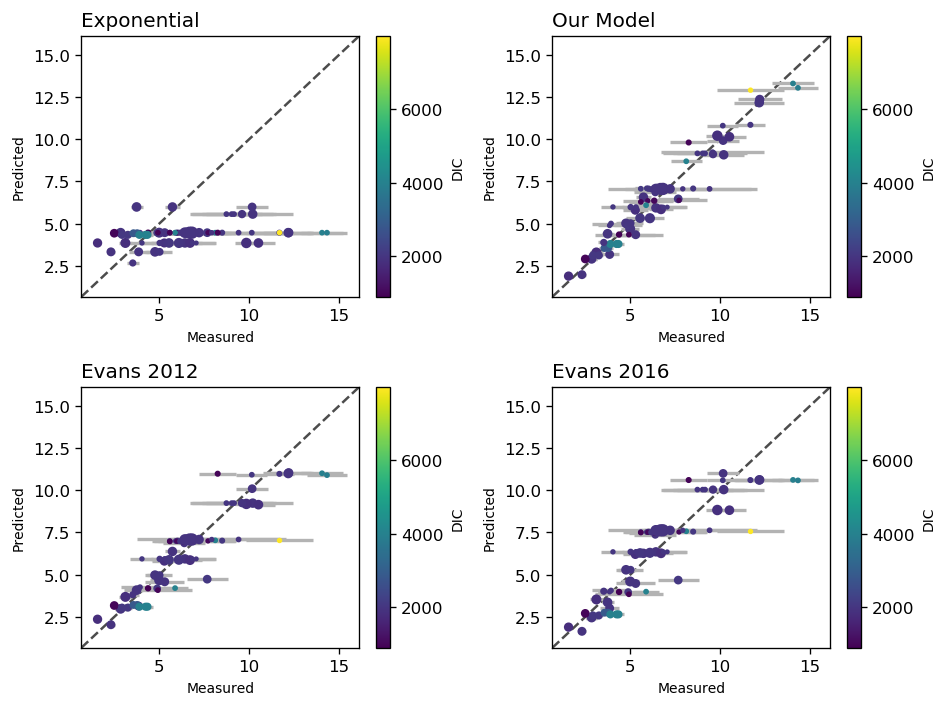

In [52]:
fig, axs = plt.subplots(2, 2, figsize=[8, 6])

# cvar = ('Measured', '[Ca]sw')
cvar = ('csys_mid', 'DIC')


# exponential
axs[0,0].set_title('Exponential', loc='left')
plot.compare(obs=dat.loc[:, ('Measured', 'Mg/Caf')], 
             pred=exp_pred,
             errs=dat.loc[:, ('Uncertainties', 'CI95')],
             c=dat.loc[:, cvar], clab=cvar[-1], 
             figax=(fig, axs[0,0]), s=dat.loc[:, ('Measured', 'numberforams')])

# our model
axs[0, 1].set_title('Our Model', loc='left')
# cvar = 'pHtot'
plot.compare(obs=dat.loc[:, ('Measured', 'Mg/Caf')], 
             pred=pred,
             errs=dat.loc[:, ('Uncertainties', 'CI95')],
             c=dat.loc[:, cvar], clab=cvar[-1], 
             figax=(fig, axs[0,1]), s=dat.loc[:, ('Measured', 'numberforams')])

# evans 2012
axs[1, 0].set_title('Evans 2012', loc='left')
# cvar = 'pHtot'
plot.compare(obs=dat.loc[:, ('Measured', 'Mg/Caf')], 
             pred=e2012_pred,
             errs=dat.loc[:, ('Uncertainties', 'CI95')],
             c=dat.loc[:, cvar], clab=cvar[-1], 
             figax=(fig, axs[1, 0]), s=dat.loc[:, ('Measured', 'numberforams')])

# evans 2015
axs[1, 1].set_title('Evans 2016', loc='left')
# cvar = 'pHtot'
plot.compare(obs=dat.loc[:, ('Measured', 'Mg/Caf')], 
             pred=e2015_pred,
             errs=dat.loc[:, ('Uncertainties', 'CI95')],
             c=dat.loc[:, cvar], clab=cvar[-1], 
             figax=(fig, axs[1, 1]), s=dat.loc[:, ('Measured', 'numberforams')])

fig.tight_layout()

fig.savefig('Plots/model_comparison.pdf')
fig.savefig('Plots/model_comparison.png')

All models are wrong, but some are more wrong than others.

- Exponential: Predicts a tital variance of 4 mmol $mol^{-1}$, while data variance is ~10 mmol $mol^{-1}$. Clearly inadequate.
- Evans 2012/2016: Though subtle differences in how they implement Mg sensitivity (power law vs. polynomial), they are functionally similar. Total predicted variance of ~8 mmol $mol^{-1}$ - much closer to reality. Tends to under-predict, particularly at highest observed Mg/Ca (>10 mmol $mol^{-1}$)
- Our Model: Variance very similar to observed. Slight tendency to under-predict, though no obvious pattern in which points are under-predicted. Points furthest from line also have largest associated uncertainties. Including the additional [Ca] and [DIC] terms offers a slight improvement over Evans' model. 

Differences in model skill can be compared using a Taylor diagram.

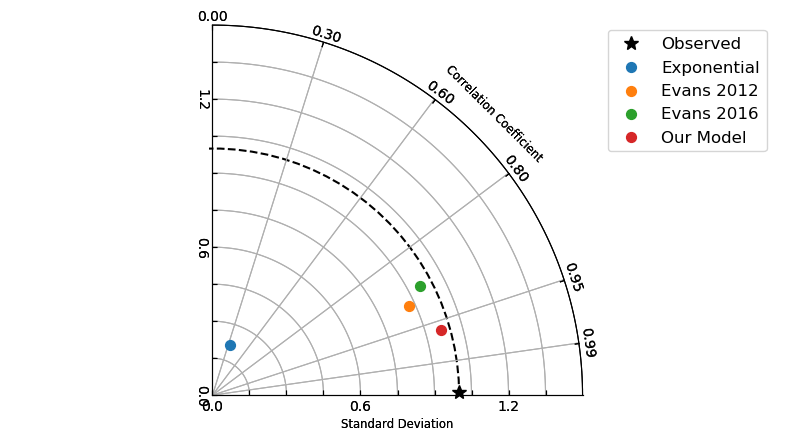

In [53]:
fig, ax = taylor_diag.Taylor_diag({0: dat.loc[:, ('Measured', 'Mg/Caf')] * 1e3,
                                   'Exponential': exp_pred * 1e3,
                                   'Evans 2012': e2012_pred * 1e3,
                                   'Evans 2016': e2015_pred * 1e3,
                                   'Our Model': pred * 1e3})

Both our and Evans' models offer significant improvements over the conventional temperature-only exponential relationship. This is because the primary influence on foraminiferal Mg/Ca is the Mg/Ca of seawater, which is included in both models. However, our data clearly resolve the independent and interactive influences of [DIC] and [Ca] with Temperature on Mg partitioning, justifying their inclusion in the model.

Our model offers a significant improvement over those of Evans', by accounting for the influence of DIC and [Ca].

Including these terms allows us to examine the sensitivity of foraminiferal Mg/Ca to these parameters in isolation.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 6. Model Fit Uncertainties<a id='mc_uncertainties'></a>

For convenience, our model fits have been weighted by 1/N to account for sample size. We now explore the effects of measurement uncertainties by Monte-Carlo error resampling.

In [54]:
# resample parameters within uncertainties
rerun = False

if not os.path.exists('Data/MonteCarloOutput.npy') or rerun:
    N = 10000

    # initialise variables
    MgCasw = np.random.normal(dat.loc[:, ('Measured', 'Mg/Casw')], 0.1, (N, dat.shape[0]))
    Casw = np.random.normal(dat.loc[:, ('Measured', '[Ca]sw')] * 1e-3, 0.1e-3, (N, dat.shape[0]))
    DICsw = np.random.uniform(dat.loc[:, ('pitzer', 'DIC')] * 1e-6, dat.loc[:, ('MyAMI', 'DIC')] * 1e-6, (N, dat.shape[0]))
    Temp = np.random.normal(dat.loc[:, ('Measured', 'Temp')], 0.1, (N, dat.shape[0]))

    MgCaforam = np.random.normal(dat.loc[:, ('Measured', 'Mg/Caf')], dat.loc[:, ('Uncertainties', 'CI95')], (N, dat.shape[0]))

    p_opt = np.zeros((N, 5))

    for i in tqdm(range(N)):
        p, cov = curve_fit(mgca_fn, (MgCasw[i], Casw[i], DICsw[i], Temp[i]), MgCaforam[i])
        p_opt[i] = p

    np.save('Data/MonteCarloOutput', p_opt)
else:
    p_opt = np.load('Data/MonteCarloOutput.npy')

View parameter distributions and interactions

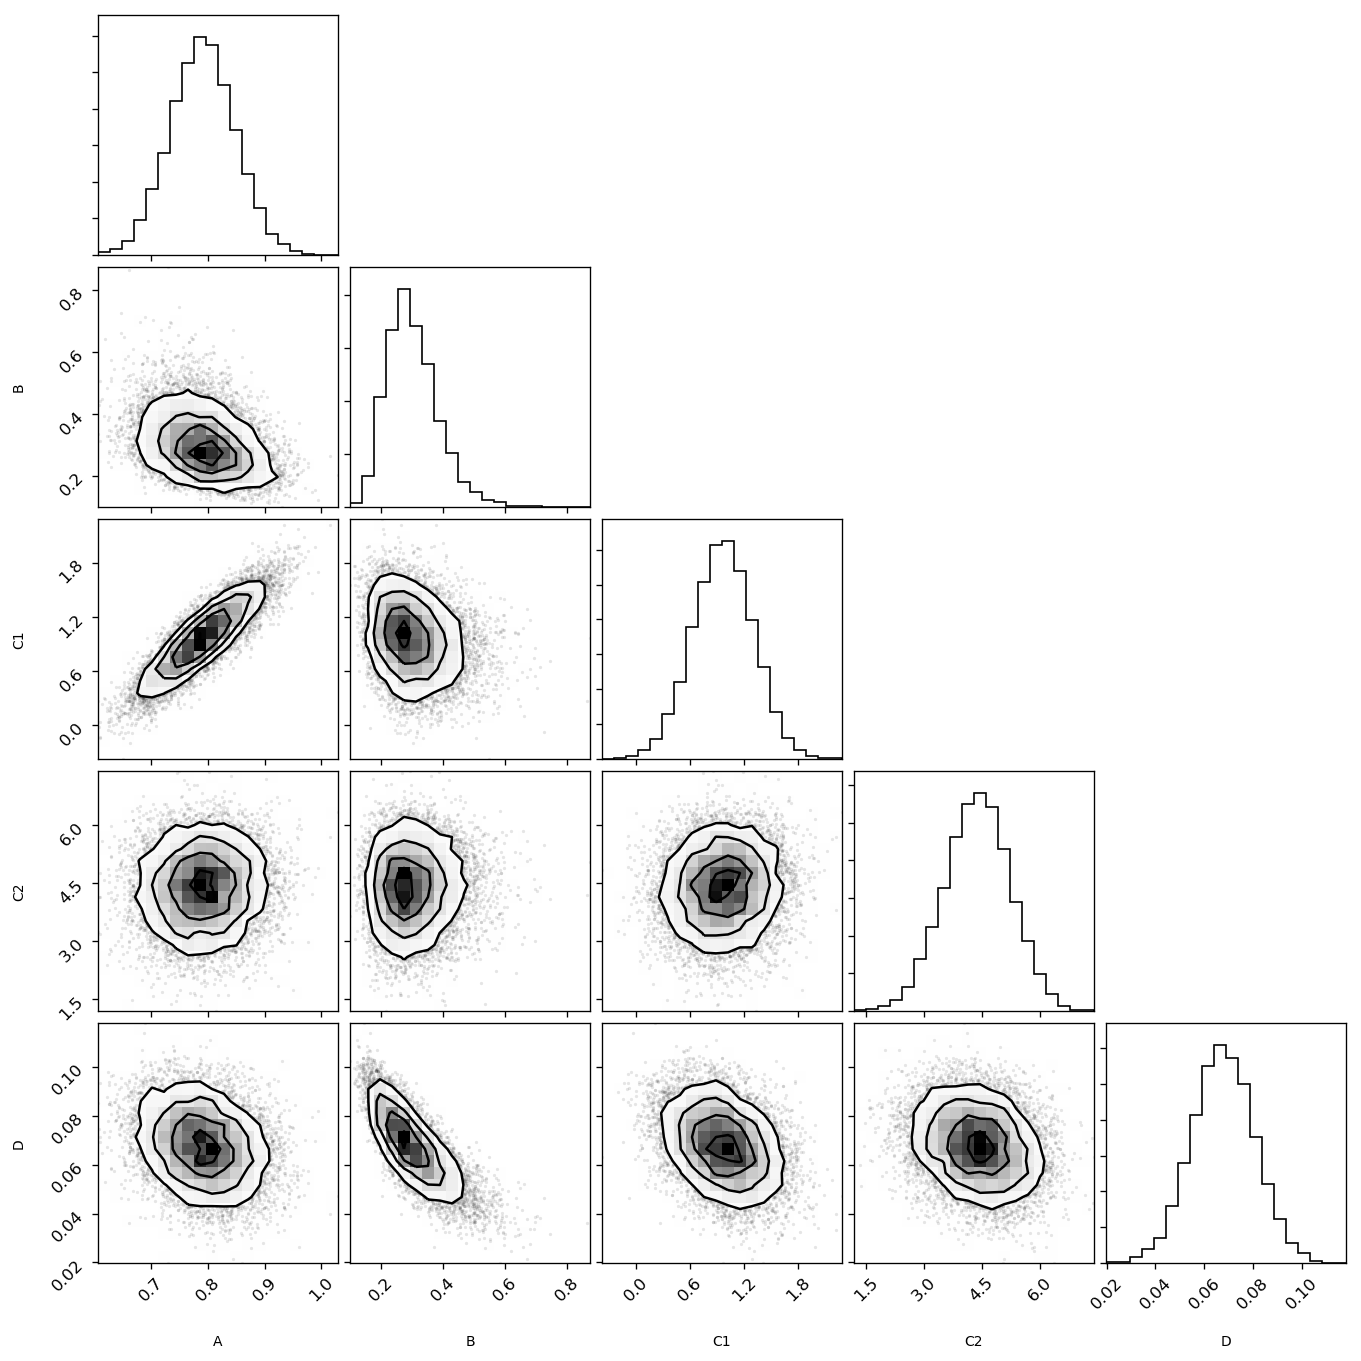

In [55]:
_ = corner.corner(p_opt, labels=['A', 'B', 'C1', 'C2', 'D'])

In [56]:
# calculate corrlation matrix
mc_cor = np.corrcoef(p_opt.T)
mc_cor[mc_cor >= 0.999] = np.nan

# calculate covariance matrix
mc_cov = np.cov(p_opt.T)

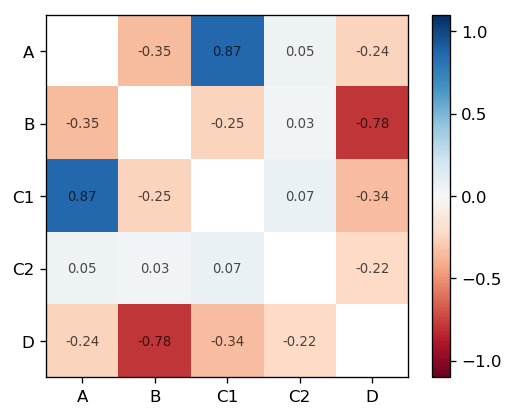

In [57]:
fig, ax = plt.subplots(1, 1, figsize=[5, 4])

mat = mc_cor

# draw image
ma = ax.imshow(mat, cmap=plt.cm.RdBu, vmax=1.1, vmin=-1.1)

# write on correlation values
for i, j in zip(*np.triu_indices(mat.shape[0])):
    if i != j:
        c = mat[i, j]
        ax.text(i, j, '{:.2f}'.format(c), va='center', ha='center', alpha=0.7, fontsize=8)
        ax.text(j, i, '{:.2f}'.format(c), va='center', ha='center', alpha=0.7, fontsize=8)

ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])
labs = ['A', 'B', 'C1', 'C2', 'D']
ax.set_xticklabels(labs)
ax.set_yticklabels(labs)

cb = fig.colorbar(ma)
cb.set_ticks(np.linspace(-1, 1, 5))

There are strong correlations between some of the parameters - most notably between A and C1, and D and B. This is not a problem, as the effects of these parameters are well resolved in the data. However, these correlations must be accounted for in uncertainty propagation.

Not accounting for these correlations will dramatically over-estimate uncertainties.

In [58]:
params = un.correlated_values(p_opt.mean(0), mc_cov)

In [59]:
# define fitting function
def u_mgca_fn(x, A, B, C1, C2, D):
    MgCa, Ca, C, T = x
    return MgCa**A * B * un.unumpy.exp((C1 * Ca + C2 * C + D) * T)

# package data for fitting
x = (dat.loc[:, ('Measured', 'Mg/Casw')],  # molar ratio (unitless)
     dat.loc[:, ('Measured', '[Ca]sw')] * 1e-3,  # molar
     dat.loc[:, ('csys_mid', 'DIC')] * 1e-6,  # molar
     dat.loc[:, ('Measured', 'Temp')])  # celcius

obs = dat.loc[:, ('Measured', 'Mg/Caf')]
obs_err = dat.loc[:, ('Uncertainties', 'CI95')]

pred = u_mgca_fn(x, *params)

In [60]:
print(("Optimised Parameters\n" +
      "   A: {:.3f}\n".format(params[0]) +
      "   B: {:.3f}\n".format(params[1]) +
      "   C1: {:.3f}\n".format(params[2]) +
      "   C2: {:.3f}\n".format(params[3]) +
      "   D: {:.3f}\n".format(params[4])))

Optimised Parameters
   A: 0.791+/-0.057
   B: 0.301+/-0.083
   C1: 0.965+/-0.335
   C2: 4.387+/-0.853
   D: 0.068+/-0.013



Although note that these uncertainties cannot be linearly propagated, as there is significant covariance in the fit parameters.

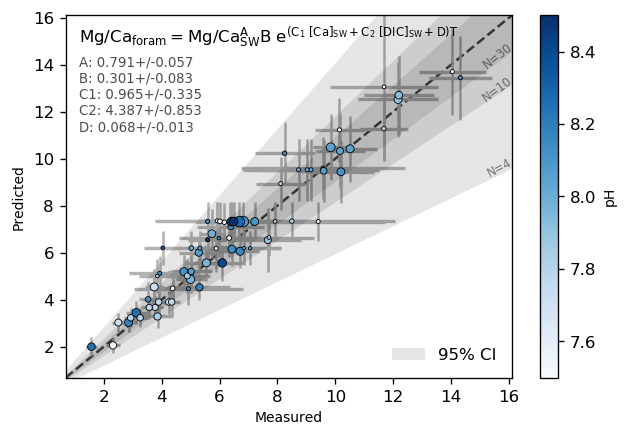

In [61]:
ind = np.ones(dat.shape[0], dtype=bool)

fig, ax = plot.compare(obs=dat.loc[ind, ('Measured', 'Mg/Caf')], 
                       pred=nom(pred[ind]),
                       errs=dat.loc[ind, ('Uncertainties', 'CI95')],
                       c=dat.loc[ind, ('csys_mid', 'pHtot')],
                       clab='pH', cmap=plt.cm.Blues, lw=0.5, edgecolor='k',
                       s=dat.loc[ind, ('Measured', 'numberforams')], vmin=7.5, vmax=8.5)

ax.errorbar(obs[ind], nom(pred[ind]), 
            yerr=1.96 * err(pred[ind]), lw=0, elinewidth=1.5, capsize=0, c=(.7,.7,.7), zorder=-1)

label1 = '$Mg/Ca_{foram} = Mg/Ca_{SW}^A B\ e^{(C_1\ [Ca]_{SW} + C_2\ [DIC]_{SW} + D) T}$\n'

label2 = ("A: {:.3f}\n".format(params[0]) +
          "B: {:.3f}\n".format(params[1]) +
          "C1: {:.3f}\n".format(params[2]) +
          "C2: {:.3f}\n".format(params[3]) +
          "D: {:.3f}\n".format(params[4]))

ax.text(.03, .99, label1, ha='left', va='top', transform = ax.transAxes, fontsize=10)
ax.text(.03, .89, label2, ha='left', va='top', transform = ax.transAxes, fontsize=8, color=(.3,.3,.3))

lim = np.array(ax.get_xlim())
for n in [4, 10, 30]:
    i = stats.t.interval(0.95, df=n-1)[-1]
    if n == 4:
        lab = '95% CI'
    else:
        lab = '_'
    ax.fill_between(lim, 
                    lim + i * (lim * ifa_rsd) / n**0.5, 
                    lim - i * (lim * ifa_rsd) / n**0.5, 
                    alpha=0.1, color='k', lw=0, zorder=-1, label=lab)

ax.text(16.2, 9.7, 'N=4',  ha='right', rotation=28, fontsize=7, alpha=0.5)
ax.text(16.2, 13.2, 'N=10', ha='right', rotation=36, fontsize=7, alpha=0.5)
ax.text(16.2, 14.6, 'N=30', ha='right', rotation=38, fontsize=7, alpha=0.5)

ax.legend(loc='lower right', framealpha=0)

A model vs. data plot using the Monte-Carlo calculated uncertainties. Shaded bars represent measurement 95% confidence intervals for foraminiferal Mg/Ca measurements, given different Mg/Ca concentrations and sample sizes.

#### Predict Temperature

In [62]:
pred_T = T_fn_u(xt, *params)

# calculate predicted T error arising from foram variability at modern conditions
mgca_s = np.linspace(2, 15)
dic = 2000e-6
ca = 10.2e-3
mgcasw = 5.1

med_ifa = nom(T_fn((mgca_s, mgcasw, dic, ca), *p))

cis_lower = []
cis_upper = []

for n in [4, 10, 30]:
    m = ifa_rsd * stats.t.interval(0.95, df=n-1)[-1] / n**0.5
    cis_upper.append(nom(T_fn((mgca_s + mgca_s * m, mgcasw, dic, ca), *p)))
    cis_lower.append(nom(T_fn((mgca_s - mgca_s * m, mgcasw, dic, ca), *p)))

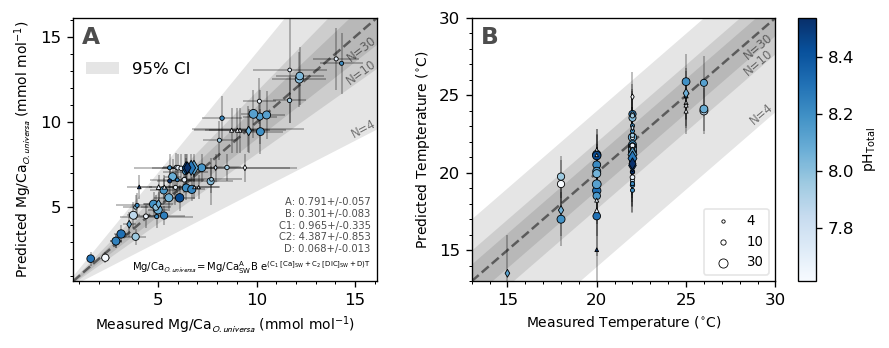

In [63]:
fig, ax = figures.fig4(dat, params, pred, pred_T, ifa_rsd, mdict, cis_upper, cis_lower, med_ifa)

fig.savefig('Plots/04_model_comparison.pdf')
fig.savefig('Plots/04_model_comparison.png')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 6.1 How well do our parameters explain previous data? <a id='otherdata'></a>

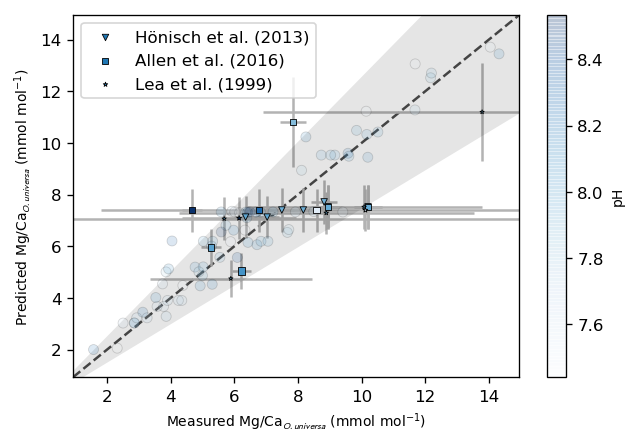

In [64]:
otherx = (otherdat.loc[:, ('Measured', 'Mg/Casw')],  # molar ratio (unitless)
          otherdat.loc[:, ('Measured', '[Ca]sw')] * 1e-3,  # molar
          otherdat.loc[:, ('csys_mid', 'DIC')] * 1e-6,  # molar
          otherdat.loc[:, ('Measured', 'Temp')])  # celcius
otherpred = u_mgca_fn(otherx, *params)

fig, ax = plot.compare(obs=dat.loc[:, ('Measured', 'Mg/Caf')], 
                       pred=nom(pred),
                       errs=None,  #dat.loc[:, ('Measured', 'Mg/Caf 2se')],
                       c=dat.loc[:, ('csys_mid', 'pHtot')],
                       clab='pH', cmap=plt.cm.Blues, lw=0.5, edgecolor='k', alpha=0.15)

s = otherdat.loc[:, ('Measured', 'numberforams')]
for k, m in mdict.items():        
    ind = otherdat.Measured.who == k
    if not any(ind):
        continue
    
    sub = otherdat.loc[ind]
    ax.scatter(sub.loc[:, ('Measured', 'Mg/Caf')],
               nom(otherpred[ind]), c=sub.loc[:, ('csys_mid', 'pHtot')],
               cmap=plt.cm.Blues, lw=0.5, edgecolor='k', vmin=7.5, vmax=8.5, marker=m, s=s[ind], label=ldict[k])

    ax.errorbar(otherdat.loc[ind, ('Measured', 'Mg/Caf')], nom(otherpred[ind]), 
                yerr=1.96 * err(otherpred[ind]), 
                xerr=otherdat.loc[ind, ('Uncertainties', 'CI95')],
                lw=0, elinewidth=1.5, capsize=0, c=(.7,.7,.7), zorder=-1)

ax.set_xlabel('Measured $Mg/Ca_{\it{O. universa}}$ (mmol $mol^{-1}$)')
ax.set_ylabel('Predicted $Mg/Ca_{\it{O. universa}}$ (mmol $mol^{-1}$)')

ax.legend()

lim = np.array(ax.get_xlim())
ax.fill_between(lim, lim + lim * ifa_rsd, lim - lim * ifa_rsd, alpha=0.1, color='k', lw=0, zorder=-1, label='Mg/Ca $1\sigma$')

fig.savefig('Plots/S_model_appl_to_others.pdf')
fig.savefig('Plots/S_model_appl_to_others.png')

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


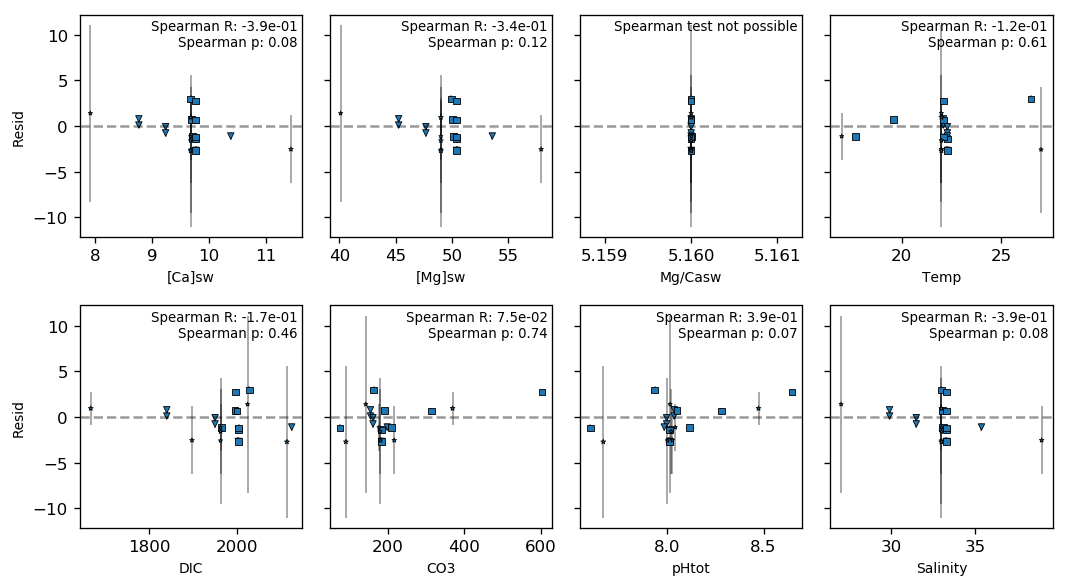

In [65]:
vari = (('Measured', '[Ca]sw'),
        ('Measured', '[Mg]sw'),
        ('Measured', 'Mg/Casw'),
        ('Measured', 'Temp'),
        ('csys_mid', 'DIC'),
        ('csys_mid', 'CO3'),
        ('csys_mid', 'pHtot'),
        ('Measured', 'Salinity'))

other_resid = nom(otherpred - otherdat.loc[:, ('Measured', 'Mg/Caf')])

fig, axs = plt.subplots(2, 4, figsize=(9, 5), sharey=True)

s = otherdat.loc[:, ('Measured', 'numberforams')]

for v, ax in zip(vari, axs.flatten()):
    
    for k, m in mdict.items():        
        ind = otherdat.Measured.who == k
        
        dep = otherdat.loc[ind, v]
        r = other_resid[ind]
        si = s.loc[ind]
        
        ax.scatter(dep, r, zorder=2, marker=m, c='C0', edgecolor='k', lw=0.5, s=si)
        ax.errorbar(dep, r, yerr= otherdat.loc[ind, ('Uncertainties', 'CI95')],
                    lw=0, elinewidth=1, color=(0,0,0,0.4), zorder=-1)
    
    nancatch = ~(np.isnan(otherdat.loc[:, v]) | np.isnan(other_resid))
    R, sp = stats.spearmanr(otherdat.loc[nancatch, v], other_resid[nancatch])
    if not np.isnan(R):
        if sp < 0.01:
            spt = '< 0.01'
        else:
            spt = '{:.2f}'.format(sp)
        stat_text = 'Spearman R: {:.1e}\nSpearman p: {}'.format(R, spt)
    else:
        stat_text = "Spearman test not possible"
    ax.text(.98, .98, stat_text, va='top', ha='right', transform=ax.transAxes, fontsize=8)
    
    ax.set_xlabel(v[-1])
    if ax.is_first_col():
        ax.set_ylabel('Resid')
        
    ax.axhline(0, ls='dashed', color=(0,0,0,0.4))
    
fig.tight_layout()

The only significant correlation in the residuals is in pH/CO3, which is not a factor in our model.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 7. Mg/Ca Sensitivity Analysis<a id='sensitivity'></a>

$$
T = \frac{ln\left(\frac{Mg/Ca_{foram}}{Mg/Ca_{SW}\ ^A B}\right)}{(C_1\ [Ca]_{SW} + C_2\ [DIC]_{SW} + D)}
$$

$$
\frac{\Delta T}{\Delta Mg/Ca_{foram}} = \frac{1}{Mg/Ca_{foram}(C_1\ [Ca]_{SW} + C_2\ [DIC]_{SW} + D)}
$$

In [66]:
from mg_funks.plot import lbl_position_checker, panel_coord, gradpanel

In [67]:
# Temperature function
def T_fn(x, A, B, C1, C2, D):
    """
    Calculate temperature from Mg/Casw, [Ca]sw, [C] and Mg/Caforam.
    """
    if any([isinstance(p, un.core.AffineScalarFunc) for p in [A, B, C1, C2, D]]):
        log = un.unumpy.log
    else:
        log = np.log
    MgCasw, Casw, Carb, MgCacc = x
    return log(MgCacc / (MgCasw**A * B)) / (Casw * C1 + C2 * Carb + D)

# dT / dMgCacc
def gT_fn(x, C1, C2, D):
    Casw, Carb, MgCacc = x
    return 1 / (MgCacc * (Casw * C1 + C2 * Carb + D))

# dMgCacc / dT
def gMgCa_fn(x, C1, C2, D):
    Casw, Carb, T = x
    return np.exp((C1 * Casw + C2 * Carb + D) * T)

nom_params = nom(params)

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 7.1 Sensitivity to Individual Variables <a id='sens_indiv'></a>

In [68]:
def DIC_fn(x, A, B, C1, C2, D):
    MgCasw, Casw, MgCaforam, Temp = x
    
    return ((1 / Temp) * un.unumpy.log(MgCaforam / (MgCasw**A * B)) - D - C1 * Casw) / C2

def Ca_fn(x, A, B, C1, C2, D):
    MgCasw, DICsw, MgCaforam, Temp = x
    
    return ((1 / Temp) * un.unumpy.log(MgCaforam / (MgCasw**A * B)) - D - C2 * DICsw) / C1

def MgCasw_fn(x, A, B, C1, C2, D):
    Casw, DICsw, MgCaforam, Temp = x
    
    return (MgCaforam / (A * np.exp((C1 * Casw + C2 * DICsw + D) * Temp)))**(1/B)

In [69]:
iT = np.linspace(15, 30, 500)
iMgCaf = np.linspace(3, 13, 500)

T, MgCaf = np.meshgrid(iT, iMgCaf)

pDIC = DIC_fn((5., 10.2e-3, MgCaf, T), *nom_params).astype(float)
pCa = Ca_fn((5., 2000e-6, MgCaf, T), *nom_params).astype(float)
pMgCasw = MgCasw_fn((10.2e-3, 2000e-6, MgCaf, T), *nom_params).astype(float)

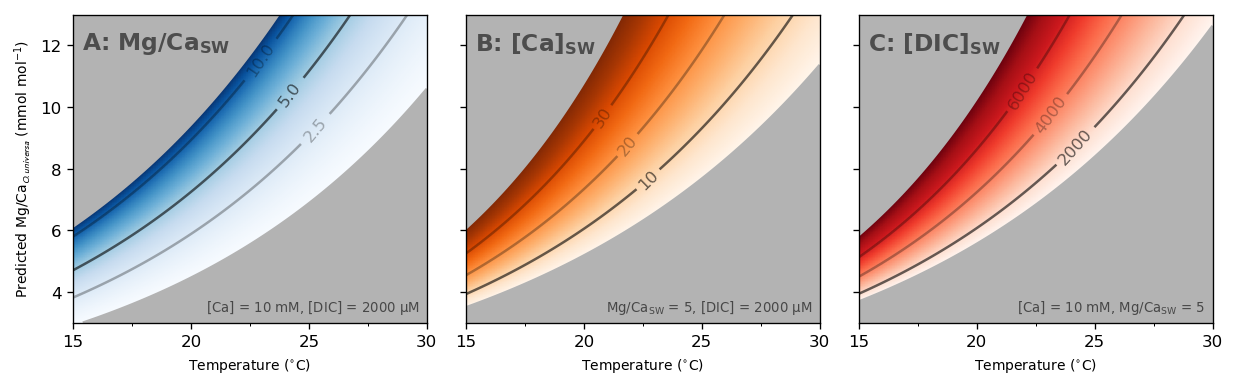

In [70]:
cm = plt.cm.Blues_r
cm.set_bad(  (.8,.8,.8, 0))
cm.set_under((.8,.8,.8, 0))
cm.set_over( (.8,.8,.8, 0))

w = 88 / 25.4
size = (w * 3, w * .9)

fig, (MgCasw_axs, Casw_axs, DIC_axs) = plt.subplots(1, 3, sharey=True, figsize=size)

axs = MgCasw_axs, Casw_axs, DIC_axs


# Mg/CaSW plot
cmb = plt.cm.Blues
cmb.set_over((.7, .7, .7))
cmb.set_under((.7, .7, .7))

ma = MgCasw_axs.pcolormesh(T, MgCaf, pMgCasw, cmap=cmb, vmin=1, vmax=12)
cs = MgCasw_axs.contour(T, MgCaf, pMgCasw, [2.5, 5, 10], colors=[(0,0,0,0.3),(0,0,0,0.6),(0,0,0,0.3)])
MgCasw_axs.contour(T, MgCaf, pMgCasw, [1, 12], colors=[(.7,.7,.7)])
plot.contour_labels(cs, MgCasw_axs, fmt='%0.1f', hshift=.4, vshift=.2)


MgCasw_axs.text(0.98, 0.02, '[Ca] = 10 mM, [DIC] = 2000 $\mu$M', va='bottom', ha='right', 
                transform=MgCasw_axs.transAxes, color=(0,0,0,0.6), fontsize=8)

# Ca plot
cmo = plt.cm.Oranges
cmo.set_over((.7, .7, .7))
cmo.set_under((.7, .7, .7))

Casw_axs.pcolormesh(T, MgCaf, pCa, cmap=cmo, vmin=2e-3, vmax=40e-3)
cs = Casw_axs.contour(T, MgCaf, pCa * 1e3, [10, 20, 30], colors=[(0,0,0,0.6),(0,0,0,0.3),(0,0,0,0.3)])

Casw_axs.contour(T, MgCaf, pCa * 1e3, [2, 40], colors=[(.7,.7,.7)])
plot.contour_labels(cs, Casw_axs, fmt='%0.0f')

Casw_axs.text(0.98, 0.02, 'Mg/Ca$_{SW}$ = 5, [DIC] = 2000 $\mu$M', va='bottom', ha='right', 
                transform=Casw_axs.transAxes, color=(0,0,0,0.6), fontsize=8)

# DIC plot
cmr = plt.cm.Reds
cmr.set_over((.7, .7, .7))
cmr.set_under((.7, .7, .7))

DIC_axs.pcolormesh(T, MgCaf, pDIC, cmap=cmr, vmin=1000e-6, vmax=8000e-6)
cs = DIC_axs.contour(T, MgCaf, pDIC * 1e6, [2000, 4000, 6000], colors=[(0,0,0,0.6),(0,0,0,0.3),(0,0,0,0.3)])
DIC_axs.contour(T, MgCaf, pDIC * 1e6, [1000, 8000], colors=[(.7,.7,.7)])
plot.contour_labels(cs, DIC_axs, fmt='%0.0f', hshift=.3)

DIC_axs.text(0.98, 0.02, '[Ca] = 10 mM, Mg/Ca$_{SW}$ = 5', va='bottom', ha='right', 
                transform=DIC_axs.transAxes, color=(0,0,0,0.6), fontsize=8)

MgCasw_axs.set_ylabel("$Predicted\ Mg/Ca_{\it{O. universa}}\ (mmol\ mol^{-1})$")

fig.tight_layout()


for ax, lab in zip(axs, ['A: $Mg/Ca_{SW}$', 'B: $[Ca]_{SW}$', 'C: $[DIC]_{SW}$']):
    ax.set_xlabel('$Temperature\ (^{\circ}C)$')
    ax.text(.025, .95, lab, ha='left', va='top', transform=ax.transAxes, 
            weight="bold", fontsize=14, color=(.3, .3, .3), zorder=2)
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2.5))
    
fig.savefig('Plots/06_Sensitivity.png', dpi=600)

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 7.2 Relative Sensitivities <a id='sens_rel'></a>

How sensitive is Mg/Ca to parameters other than temperature?

To assess this, we calculate the change in Mg/Ca<sub>*O. universa*</sub> that would result from a temperature elevation from 22 to 23 C at ambient conditions. We then determine how much [Ca], Mg/Ca<sub>SW</sub> or DIC would have to change to produce a similar change in Mg/Ca<sub>*O. universa*</sub>

In [71]:
from scipy import optimize as opt

In [72]:
MgCasw, Casw, DICsw = 5, 10.2e-3, 2000e-6

T_delta = mgca_fn((MgCasw, Casw, DICsw, 23.), *nom_params) - mgca_fn((MgCasw, Casw, DICsw, 22.), *nom_params)

def Casw_delta(del_Casw, T_delta):
    delta = mgca_fn((5, 10.2e-3 + del_Casw, 2000e-6, 22.), *nom_params) - mgca_fn((5, 10.2e-3, 2000e-6, 22.), *nom_params)
    return (delta - T_delta)**2

def DICsw_delta(del_DICsw, T_delta):
    delta = mgca_fn((5, 10.2e-3, 2000e-6 + del_DICsw, 22.), *nom_params) - mgca_fn((5, 10.2e-3, 2000e-6, 22.), *nom_params)
    return (delta - T_delta)**2

def MgCasw_delta(del_MgCasw, T_delta):
    delta = mgca_fn((5 + del_MgCasw, 10.2e-3, 2000e-6, 22.), *nom_params) - mgca_fn((5, 10.2e-3, 2000e-6, 22.), *nom_params)
    return (delta - T_delta)**2

In [73]:
mgca_fn((MgCasw, Casw, DICsw, 23.), *nom_params), mgca_fn((MgCasw, Casw, DICsw, 22.), *nom_params)

(7.870052307410251, 7.218013339944729)

In [74]:
Ca_delta = opt.minimize(Casw_delta, 0, args=(T_delta))
DIC_delta = opt.minimize(DICsw_delta, 0, args=(T_delta))
MgCa_delta = opt.minimize(MgCasw_delta, 0, args=(T_delta))

In [75]:
# Mg/Ca change resulting from 1C temperature increase from 22->23C at ambient conditions
T_delta

0.652038967465522

In [76]:
# mmol kg [Ca] change (assuming constant Mg/Ca) required to cause the same change in foram Mg/Ca
Ca_delta.x * 1e3

array([4.07256045])

In [77]:
# umol kg Ca change required to cause the same change in foram Mg/Ca
DIC_delta.x * 1e6

array([896.0840293])

In [78]:
# Mg/Ca change required to cause the same change in foram Mg/Ca
MgCa_delta.x

array([0.57754269])

In [79]:
# mmol kg [Mg] change (assuming constant Ca) required to cause the same change in foram Mg/Ca
((5 + MgCa_delta.x) * 10.2) - (5. * 10.2)

array([5.89093545])

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 7.3 Propagation of Uncertainties to T reconstructions. <a id='unc_prop'></a>

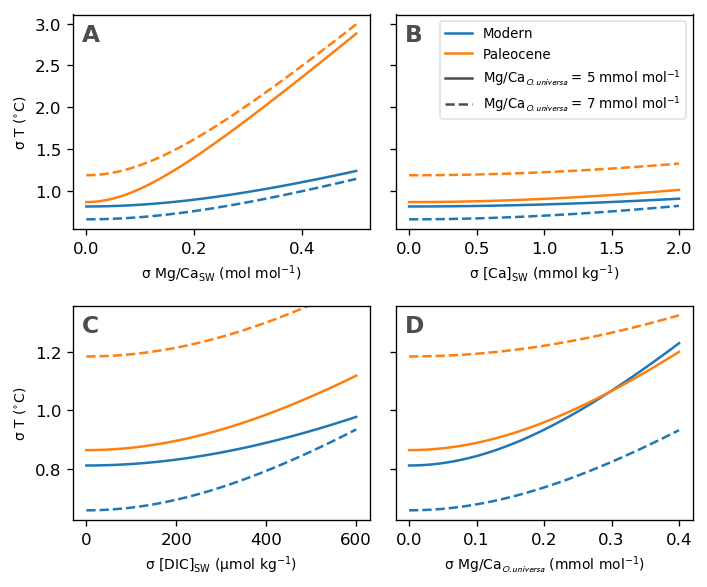

In [80]:
fig, axs = figures.fig8(params)

fig.savefig('Plots/08_Uncertainty_Propagation.pdf')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 7.4 Past Seawater Conditions <a id='past_sw'></a>

In [81]:
idx = pd.IndexSlice

psw = pd.read_excel('Data/Past_SW.xlsx', header=(0, 1), index=None)
psw.reset_index(drop=True, inplace=True)
psw.sort_index(1, inplace=True)

r = psw.loc[0,idx[:,('Max','Min')]]

#### Smooth Mg/Ca record using Gaussian-weigted moving average

In [82]:
xn = np.linspace(0, 120, 500)

# sort values by age
apsw = psw.sort_values(('Age (Myr)', 'Mean'))

In [83]:
# isolate Mg/Ca data
dmgca = apsw.loc[~np.isnan(apsw.loc[:, ('Mg/Casw (mol/mol)', 'Mean')]),
                 idx[('Age (Myr)', 'Mg/Casw (mol/mol)', 'Reference'), ('Mean','Reference')]]

xr_mgca = dmgca.loc[:, ('Age (Myr)', 'Mean')].values
yr_mgca = dmgca.loc[:, ('Mg/Casw (mol/mol)', 'Mean')].values
ref_mg = dmgca.loc[:, ('Reference', 'Reference')].values

In [84]:
# Mg/Ca Smoothing
yn_mgca = weighted_moving_average(xr_mgca, yr_mgca, xn, 15)

# PETM Mg/Ca
weighted_moving_average(xr_mgca, yr_mgca, np.array([56.]), 15)

{'mean': array([2.09521976]),
 'std': array([0.33347463]),
 'stderr': array([0.07860073])}

#### Approximate Ca trend as linear

In [85]:
# isolate Ca data
dca = apsw.loc[~np.isnan(apsw.loc[:, ('Casw (mM)', 'Mean')]),
               idx[('Age (Myr)', 'Casw (mM)', 'Reference'), ('Mean', 'Min', 'Max','Reference')]]

# Ca Smoothing
xr_ca = dca.loc[:, ('Age (Myr)', 'Mean')].values
yr_ca = dca.loc[:, ('Casw (mM)', 'Mean')].values
ref_ca = dca.loc[:, ('Reference', 'Reference')].values

# with uncertainties.
xr_ca_e = np.concatenate([dca.loc[:, ('Age (Myr)', 'Mean')].values,
                   dca.loc[:, ('Age (Myr)', 'Min')].values,
                   dca.loc[:, ('Age (Myr)', 'Max')].values])  # add min & max values to incorporate uncertainties
yr_ca_e = np.concatenate([dca.loc[:, ('Casw (mM)', 'Mean')].values,
                        dca.loc[:, ('Casw (mM)', 'Min')].values,
                        dca.loc[:, ('Casw (mM)', 'Max')].values])
# ref_ca_e = np.concatenate([dca.loc[:, ('Reference', 'Reference')].values] * 3)

# exclude data > 120kr
yr_ca = yr_ca[xr_ca < 120]
ref_ca = ref_ca[xr_ca < 120]
xr_ca = xr_ca[xr_ca < 120]

yr_ca_e = yr_ca_e[xr_ca_e < 120]
# ref_ca_e = ref_ca[xr_ca < 120]
xr_ca_e = xr_ca_e[xr_ca_e < 120]

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


In [86]:
import matplotlib as mpl

In [87]:
# estimate Ca
lin = lambda x, m, c: x * m + c

p, cov = curve_fit(lin, xr_ca_e, yr_ca_e)
ca_p = un.correlated_values(p, cov)
yn_ca = lin(xn, *ca_p)


In [88]:
time = xn
T = np.linspace(15, 30, 500).reshape((500, 1))
mgcasw = yn_mgca['mean']
casw = nom(yn_ca) * 1e-3
dic = 2000e-6
mx, my = np.meshgrid(time, T)

# MgCa, Ca, C, T
MgCa_CC = mgca_fn((mgcasw, casw, dic, T), *nom(params)) 

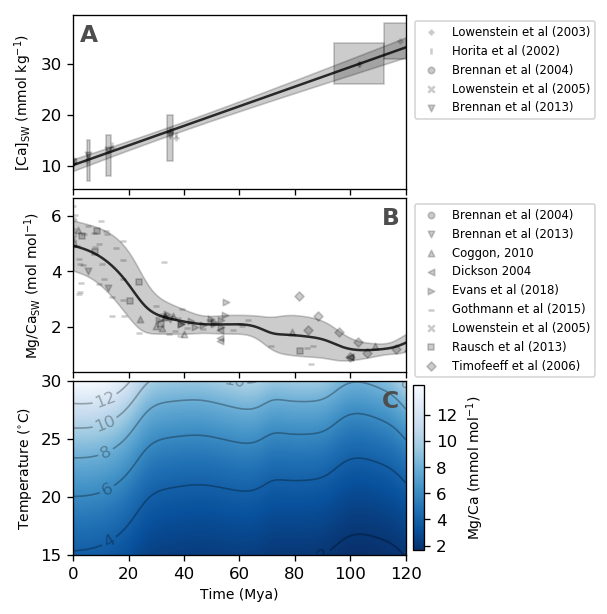

In [89]:
fig = figures.fig7(xn, yn_ca, yn_mgca, ref_ca, ref_mg, yr_mgca, xr_mgca, MgCa_CC, mx, my, dca)
    
fig.savefig('Plots/07_Past_SW_Sensitivity.png', dpi=600)

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 8. PETM Application<a id='PETM'></a>

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 8.1 Adapt our calibration to multi-species data from Anand et al (2003) <a id='multi_species'></a>

In [90]:
ad = pd.read_csv('Data/Anand_recalculated.csv', comment='#', converters={'d18Ow': un.ufloat_fromstr,
                                                                         'Ctemp': un.ufloat_fromstr,
                                                                         'sal': un.ufloat_fromstr})

# Exclude Aequilateralis and Orbulina, after Anand et al (2003).
ad = ad.loc[[s not in ['G. aequilateralis', 'O. universa', 'O. universa (thick test)'] for s in ad.Species]]

ad.loc[:, 'nom_Ctemp'] = nom(ad.loc[:, 'Ctemp'])

# Remove missing data
ad.dropna(subset=['nom_Ctemp', 'Mg/Ca (mmol/mol)'], inplace=True)

Fit the <b>B</b> and <b>D</b> parameters to Anand's data, keeping the <b>A</b> and <b>C</b> parameters from our model fit. This 'tunes' our model fit to make it applicable to other species, while preserving the sensitivity to seawater Mg/Ca, [DIC] and [Ca] determined from *O. universa*. This is imperfect, but the data required to constrain <b>A</b> and <b>C</b> for other species does not currently exist.

In [91]:
def exponent_MgCa(T, A, B):
    if isinstance(A, un.core.AffineScalarFunc) or isinstance(B, un.core.AffineScalarFunc):
        exp = un.unumpy.exp
    else:
        exp = np.exp
    
    return A * exp(B * T)

def exponent_temp(MgCa, A, B):
    if isinstance(A, un.core.AffineScalarFunc) or isinstance(B, un.core.AffineScalarFunc):
        log = un.unumpy.log
    else:
        log = np.log

    return log(MgCa / A) / B

ap, acov = curve_fit(exponent_MgCa, nom(ad.loc[:, 'Ctemp']), ad.loc[:, 'Mg/Ca (mmol/mol)'])

exp_anand_params = un.correlated_values(ap, acov)

In [92]:
def make_anand_fit(params):
    def fit_fn(x, B, D):
        if isinstance(B, un.core.AffineScalarFunc) or isinstance(D, un.core.AffineScalarFunc):
            exp = un.unumpy.exp
        else:
            exp = np.exp
        MgCa, Ca, C, T = x
        A = params[0]
        C1 = params[2]
        C2 = params[3]

        return MgCa**A * B * exp((C1 * Ca + C2 * C + D) * T)
    return fit_fn

anand_fit = make_anand_fit(nom(params))

# package data for fitting
x = ([5.] * ad.shape[0],  # Mg/Ca molar ratio (unitless)
     [10.2e-3] * ad.shape[0],  # [Ca], molar
     [2100e-6] * ad.shape[0],  # [DIC] molar
     nom(ad.loc[:, 'Ctemp']))  # celcius

# fit model
p, cov = curve_fit(anand_fit, x, ad.loc[:, 'Mg/Ca (mmol/mol)'])

# pack parameters and covariance matrix
p_errs = un.correlated_values(p, cov)



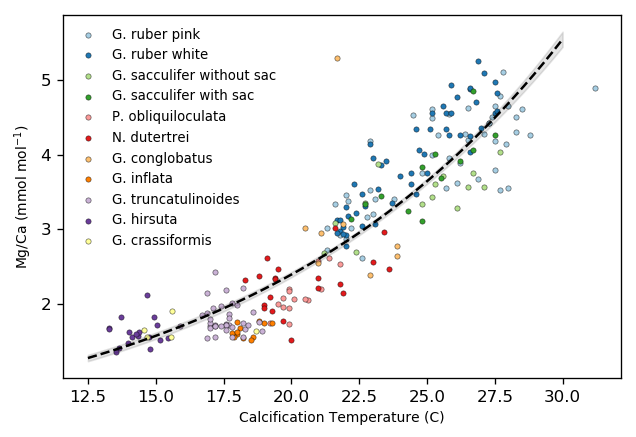

In [93]:
sdict = dict(zip(ad.Species.unique(), np.arange(ad.Species.unique().size) / ad.Species.unique().size))

fig, ax = plt.subplots(1, 1)

for s in ad.Species.unique():    
    ind = ad.Species == s
    ax.scatter(nom(ad.loc[ind, 'Ctemp']),
               nom(ad.loc[ind, 'Mg/Ca (mmol/mol)']),
               label=s, s=10, color=plt.cm.Paired(sdict[s]), lw=0.4, edgecolor=(0,0,0,0.6))

# calculate best fit line
tnew = np.linspace(12.5, 30, 50)
fit = anand_fit((5., 10.2e-3, 2000e-6, tnew), *p_errs)

ax.plot(tnew, nom(fit), c='k', ls='dashed')
ax.fill_between(tnew,
                nom(fit) - err(fit),
                nom(fit) + err(fit),
                color=(0,0,0,0.1))

ax.legend(loc='upper left', fontsize=8, framealpha=0)

ax.set_xlabel('Calcification Temperature (C)')
ax.set_ylabel('Mg/Ca (mmol $mol^{-1}$)')

fig.savefig('Plots/S_Anand_refit.pdf')

In [94]:
p_errs

(0.12451093355600185+/-0.008277158334189053,
 0.06548707859237968+/-0.002712566970554321)

Substitute Anand-derived <b>B</b> and **D** into the model fit parameters and covariance matrix for the  *Orbulina* fit.

In [95]:
anand_fit_cov = mc_cov.copy()
anand_fit_cov[1::3, 1::3] = cov

anand_fit_params = un.correlated_values((nom_params[0], p[0], nom_params[2], nom_params[3], p[1]), anand_fit_cov)

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 8.2 Apply Calibration to PETM Record <a id='PETM_app'></a>

In [96]:
petm = pd.read_csv('Data/Penman_2014_PETM.csv')

xnew = np.linspace(petm.loc[:, 'Time rel. PETM onset'].min(),
                   petm.loc[:, 'Time rel. PETM onset'].max(), 100)
time = np.linspace(petm.loc[:, 'Age_ma'].min(),
                   petm.loc[:, 'Age_ma'].max(), 100)

petm_MgCa = weighted_moving_average(xr_mgca, yr_mgca, time, 15)
petm_MgCa = un.unumpy.uarray(petm_MgCa['mean'], petm_MgCa['std'])

petm_Ca = time * ca_p[0] + ca_p[1]

# calculate gaussian-weighted moving weigted average of Mg/Ca across PETM
petm_mgca = weighted_moving_average(petm.loc[:, 'Time rel. PETM onset'], 
                                    petm.loc[:, 'Mg/Ca_mmol'],
                                    xnew, 30)

petm_mgca_eprop = un.unumpy.uarray(petm_mgca['mean'], petm_mgca['std'])

In [97]:
# load DIC datas
petm_DIC_LOSCAR = pd.read_csv('Data/DIC_Zeebe_2009.csv', comment='#').sort_values('Time_WRT_CIE')
petm_DIC_Gutjahr = pd.read_csv('Data/DIC_Gutjahr_2017.csv', comment='#').sort_values('Time_WRT_CIE')
petm_DIC_Haynes = pd.read_csv('Data/DIC_Haynes_2017.csv', comment='#').sort_values('Time_WRT_CIE')

# interpolate DIC for Temp calculation
interp_petm_DIC_LOSCAR = weighted_moving_average(petm_DIC_LOSCAR.Time_WRT_CIE, petm_DIC_LOSCAR.DIC, xnew, 15)
interp_petm_DIC_LOSCAR = un.unumpy.uarray(interp_petm_DIC_LOSCAR['mean'], interp_petm_DIC_LOSCAR['std'])

interp_petm_DIC_Gutjahr = weighted_moving_average(petm_DIC_Gutjahr.Time_WRT_CIE, petm_DIC_Gutjahr.DIC, xnew, 15)
interp_petm_DIC_Gutjahr = un.unumpy.uarray(interp_petm_DIC_Gutjahr['mean'], interp_petm_DIC_Gutjahr['std'])

interp_petm_DIC_Haynes = weighted_moving_average(petm_DIC_Haynes.Time_WRT_CIE, petm_DIC_Haynes.DIC, xnew, 15)
interp_petm_DIC_Haynes = un.unumpy.uarray(interp_petm_DIC_Haynes['mean'], interp_petm_DIC_Haynes['std'])

/home/oscar/GitHub/ForamGeochem/Supplementary/Holland_MgCa/mg_funks/helpers.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(sum((x > xn - 2 * sigma) & (x < xn + 2 * sigma)))


In [98]:
def evans2012_temp(MgCa, MgCa_t, A, B, H):
    if isinstance(A, un.core.AffineScalarFunc) or isinstance(B, un.core.AffineScalarFunc):
        log = un.unumpy.log
    else:
        log = np.log
        
    MgCa_0 = 5.17
    return log(MgCa / (B * (MgCa_t**H / MgCa_0**H))) / A

def temp_fn(MgCa_f, MgCa, Ca, Carbon, A, B, C1, C2, D):
    if isinstance(A, un.core.AffineScalarFunc) or isinstance(B, un.core.AffineScalarFunc):
        log = un.unumpy.log
    else:
        log = np.log
    
    return log(MgCa_f / (MgCa**A * B)) / (C1 * Ca + C2 * Carbon + D)


In [99]:
def plot_pred(x, y, ax, label, ebar=True, **kwargs):
    ax.plot(x, nom(y), label=label, **kwargs)
    if ebar:
        ax.fill_between(x, 
                        nom(y) - err(y),
                        nom(y) + err(y),
                        alpha=0.2, **kwargs)


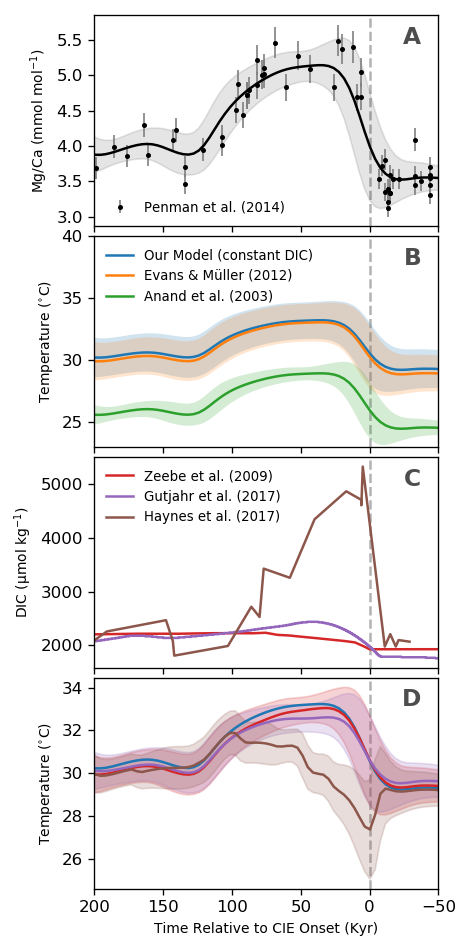

In [100]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[4,8])

dax, tax, cax, tax2 = axs

# Plot raw data
dax.errorbar(petm.loc[:, 'Time rel. PETM onset'], petm.loc[:, 'Mg/Ca_mmol'], petm.loc[:, 'Mg/Ca_mmol_std'],
             lw=0, elinewidth=1, color=(.5,.5,.5), mfc='k', mec='k', marker='o', markersize=2, label='Penman et al. (2014)')
dax.set_ylabel('Mg/Ca (mmol $mol^{-1}$)')

dax.plot(xnew, petm_mgca['mean'], c='k')
dax.fill_between(xnew, petm_mgca['mean'] - petm_mgca['std'], petm_mgca['mean'] + petm_mgca['std'], color='k', alpha=0.1, zorder=-2, label='_')

dax.legend(fontsize=8, framealpha=0)

# Plot Temperature conversion using different functions

# Our Model
petm_pred = temp_fn(petm_mgca_eprop, petm_MgCa, petm_Ca * 1e-3, 2000 * 1e-6, *anand_fit_params)
plot_pred(xnew, petm_pred, tax, label='Our Model (constant DIC)')

# Evans 2012
e2012_H = 0.41
e2012_A = un.ufloat(.09, .003)
e2012_B = un.ufloat(0.38, .02)
evans2012_pred = evans2012_temp(petm_mgca_eprop, petm_MgCa, e2012_A, e2012_B, e2012_H)
plot_pred(xnew, evans2012_pred, tax, label='Evans & Müller (2012)')

# Anand
anand_pred = exponent_temp(petm_mgca_eprop, *exp_anand_params)
plot_pred(xnew, anand_pred, tax, label='Anand et al. (2003)')


tax.set_ylim(23, 40)
tax.set_ylabel('Temperature ($^{\circ}C$)')
tax.legend(loc='upper left', fontsize=8, framealpha=0)

# DIC Records
cax.plot(petm_DIC_LOSCAR.Time_WRT_CIE, petm_DIC_LOSCAR.DIC * 1e6, label='Zeebe et al. (2009)', c='C3')
cax.plot(petm_DIC_Gutjahr.Time_WRT_CIE, petm_DIC_Gutjahr.DIC * 1e6, label='Gutjahr et al. (2017)', c='C4')
cax.plot(petm_DIC_Haynes.Time_WRT_CIE, petm_DIC_Haynes.DIC * 1e6, label='Haynes et al. (2017)', c='C5')

cax.set_ylabel('DIC ($\mu mol\ kg^{-1}$)')
cax.legend(fontsize=8, framealpha=0)

# DIC Correction
# uncorrected
plot_pred(xnew, petm_pred, tax2, label='2000', ebar=False)

# LOSCAR DIC
pred_LOSCAR = temp_fn(petm_mgca_eprop, nom(petm_MgCa), nom(petm_Ca) * 1e-3, interp_petm_DIC_LOSCAR, *anand_fit_params)
plot_pred(xnew, pred_LOSCAR, tax2, label='Zeebe et al. (2009)', color='C3')

# Gutjahr DIC
pred_Gutjahr = temp_fn(petm_mgca_eprop, nom(petm_MgCa), nom(petm_Ca) * 1e-3, interp_petm_DIC_Gutjahr, *anand_fit_params)
plot_pred(xnew, pred_Gutjahr, tax2, label='Gutjahr et al. (2017)', color='C4')

# Haynes DIC
pred_Haynes = temp_fn(petm_mgca_eprop, nom(petm_MgCa), nom(petm_Ca) * 1e-3, interp_petm_DIC_Haynes, *anand_fit_params)
plot_pred(xnew, pred_Haynes, tax2, label='Haynes et al. (2017)', color='C5')

tax2.set_ylabel('Temperature ($^{\circ}C$)')

tax2.invert_xaxis()
tax2.set_xlim(200, -50)
tax2.set_xlabel('Time Relative to CIE Onset (Kyr)')

for ax, label in zip(axs, ['A', 'B', 'C', 'D']):
    ax.axvline(0, color=(0,0,0,0.3), ls='dashed', zorder=-2)
    ax.text(.95, .95, label, ha='right', va='top', transform=ax.transAxes, weight='bold',
         fontsize=14, color=(.3, .3, .3), zorder=2)

fig.tight_layout(h_pad=0.02)

fig.savefig('Plots/PETM.pdf')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 8.2.1 Calculate T excursions in different scenarios

In [101]:
def excursion_calc(x, y):
    pre = np.mean(y[x < -30])
    post = np.max(y)
    max_time = x[nom(y) == nom(post)][0]
    return pre, post, post - pre, max_time

In [102]:
exc = {'Our_Model_NoDIC': excursion_calc(xnew, petm_pred),
       'Anand': excursion_calc(xnew, anand_pred),
       'Evans2012': excursion_calc(xnew, evans2012_pred),
       'Our_Model_LOSCAR': excursion_calc(xnew, pred_LOSCAR),
       'Our_Model_Gutjahr': excursion_calc(xnew, pred_Gutjahr),
       'Our_Model_Haynes': excursion_calc(xnew, pred_Haynes),}

excursions = pd.DataFrame(exc).T
excursions.columns = ['pre', 'post', 'excursion', 'excursion_time']

Haynes_min = excursion_calc(xnew, -pred_Haynes)
Haynes_min = -Haynes_min[0], -Haynes_min[1], -Haynes_min[2], Haynes_min[3]
excursions.loc['Our_Model_Haynes_Minimum'] = Haynes_min

excursions

pre        post   excursion excursion_time
Our_Model_NoDIC             29.3+/-0.8  33.2+/-1.5   3.9+/-1.5        37.4242
Anand                     24.57+/-0.27  29.0+/-0.6   4.4+/-0.7        37.4242
Evans2012                   28.9+/-1.2  33.1+/-1.5   4.1+/-1.0        37.4242
Our_Model_LOSCAR            29.4+/-0.6  33.0+/-0.7   3.6+/-0.7        33.6566
Our_Model_Gutjahr           29.6+/-0.6  32.6+/-0.8   3.0+/-0.8        29.8889
Our_Model_Haynes            29.2+/-0.6  31.9+/-1.0   2.7+/-1.0        97.7071
Our_Model_Haynes_Minimum    29.2+/-0.6  27.4+/-2.3  -1.8+/-2.2      -0.252525

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 8.3 Estimate DIC from Mg/Ca and $\delta^{18}O$ <a id='DIC_d18O'></a>

#### 8.3.1 Combine Penman Mg/Ca with Zachos d18O

In [103]:
# d18O data from Zachos et al (2003)
zdf = pd.read_csv('Data/Zachos_2003_d18OT.csv')
# Mg/Ca data from Zachos et al (2003)
zmg = pd.read_csv('Data/Zachos_2003_MgCa.csv')

Text(0, 0.5, 'Mg/Ca')

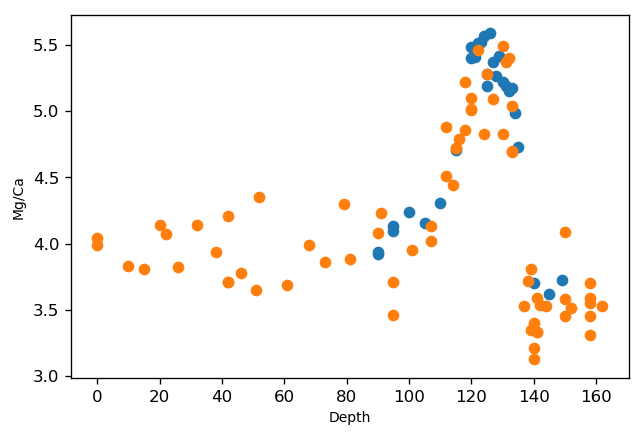

In [104]:
# compare and align Zachos and Penman Records eyball-o-metrically (M.J. Ellwood, pers. comm.)
offset = 90  # start of Zachos record in Penman's Depth scale
plt.scatter((zmg.Compositedepth_mcd - zmg.Compositedepth_mcd.min()) * 100 + offset, zmg.MgCa_mmolmol)
plt.scatter(petm.loc[:, 'Depth_cm'], petm.loc[:, 'Mg/Ca_mmol'])
plt.xlabel('Depth')
plt.ylabel('Mg/Ca')

In [105]:
# interpolate Penman's ages onto Zachos' data
zmg.loc[:, 'Depth_cm_Penman'] = (zmg.Compositedepth_mcd - zmg.Compositedepth_mcd.min()) * 100 + offset
zdf.loc[:, 'Depth_cm_Penman'] = (zdf.Compositedepth_mcd - zdf.Compositedepth_mcd.min()) * 100 + offset

zmg.loc[:, 'Age_ma'] = np.interp(zmg.loc[:, 'Depth_cm_Penman'], petm.loc[:, 'Depth_cm'], petm.loc[:, 'Age_ma'])
zdf.loc[:, 'Age_ma'] = np.interp(zdf.loc[:, 'Depth_cm_Penman'], petm.loc[:, 'Depth_cm'], petm.loc[:, 'Age_ma'])

zmg.loc[:, 'Time rel. PETM onset'] = 1e3 * (56 - zmg.loc[:, 'Age_ma'])
zdf.loc[:, 'Time rel. PETM onset'] = 1e3 * (56 - zdf.loc[:, 'Age_ma'])

Text(0, 0.5, 'Mg/Ca')

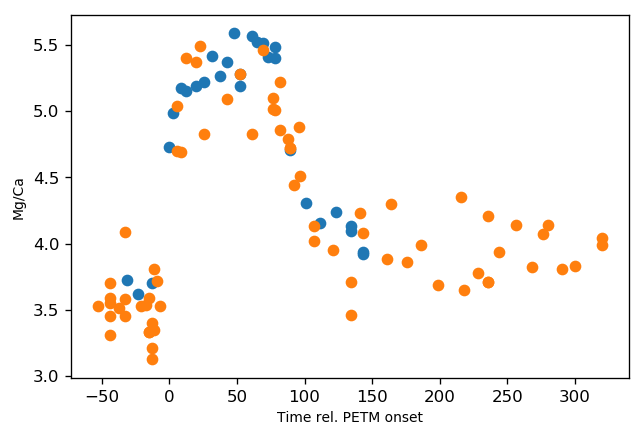

In [106]:
plt.scatter(zmg.loc[:, 'Time rel. PETM onset'], zmg.MgCa_mmolmol)
plt.scatter(petm.loc[:, 'Time rel. PETM onset'], petm.loc[:, 'Mg/Ca_mmol'])

plt.xlabel('Time rel. PETM onset')
plt.ylabel('Mg/Ca')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

#### 8.3.2 Calculate moving average d18O-derived temperature across the PETM

Text(0, 0.5, '$\\delta^{18}O$-derived Temperature')

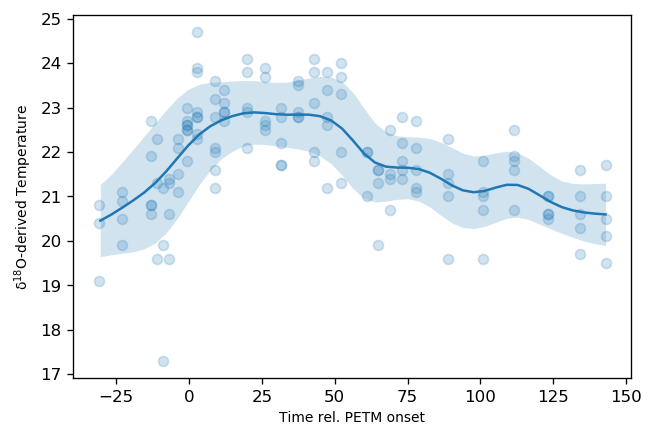

In [107]:
zx = zdf.loc[:, 'Time rel. PETM onset']
zy = zdf.Temp

time_ind = (xnew >= zx.min()) & (xnew <= zx.max())

zxnew = xnew[time_ind]
temp18O = weighted_moving_average(zx, zy, zxnew, fwhm=20)

plt.scatter(zx, zy, alpha=0.2)
plt.plot(zxnew, temp18O['mean'])
plt.fill_between(zxnew, temp18O['mean'] - temp18O['std'], temp18O['mean'] + temp18O['std'], alpha=0.2, color='C0', lw=0)

plt.xlabel('Time rel. PETM onset')
plt.ylabel('$\delta^{18}O$-derived Temperature')

The absolute temperatures here are too low, as discussed in Zachos et al (2003). We will therefore use the $\Delta T$ in this record, and apply it to the pre-PETM average Mg/Ca-calculated temperature, to estimate a temperature excursion across the PETM 

In [108]:
temp18O['delta'] = temp18O['mean'] - temp18O['mean'][0]

delta_temp = un.unumpy.uarray(temp18O['delta'], temp18O['std'])

In [109]:
# combine penman and zachos Mg/Ca data, and calculate moving weighted average across the PETM

ozmgx = zmg.loc[:, 'Time rel. PETM onset']
ozmgy = zmg.MgCa_mmolmol

pzmgx = petm.loc[:, 'Time rel. PETM onset']
pzmgy = petm.loc[:, 'Mg/Ca_mmol']

zmgx = np.concatenate([ozmgx, pzmgx])
zmgy = np.concatenate([ozmgy, pzmgy])

zMgCa = weighted_moving_average(zmgx, zmgy, zxnew, fwhm=20)
uzMgCa = un.unumpy.uarray(zMgCa['mean'], zMgCa['std'])


In [110]:
def DIC_fn(x, A, B, C1, C2, D):
    MgCasw, Casw, MgCaforam, Temp = x
    
    return ((1 / Temp) * un.unumpy.log(MgCaforam / (MgCasw**A * B)) - D - C1 * Casw) / C2

In [111]:
# calculate DIC from Mg/Ca and temperature

z_petm_MgCa = nom(petm_MgCa[time_ind])
z_petm_Ca = nom(petm_Ca[time_ind]) * 1e-3
z_pre_petm_DIC = 2000e-6

pre_petm_MgCa = un.ufloat(zmgy[zmgx < -15].mean(), zmgy[zmgx < -15].std())

# 1. calculate pre-PETM temperature
pre_PETM = (z_petm_MgCa[0], z_petm_Ca[0], z_pre_petm_DIC, pre_petm_MgCa)  # note assuming 2000 DIC pre-petm
pre_temp = T_fn(pre_PETM, *anand_fit_params)


# 2. apply deltaT from 18O across PETM
petm_18O_temp = pre_temp + delta_temp

# 3. calculate DIC
petm_DIC = DIC_fn((z_petm_MgCa, z_petm_Ca, uzMgCa, petm_18O_temp), *anand_fit_params) * 1e6

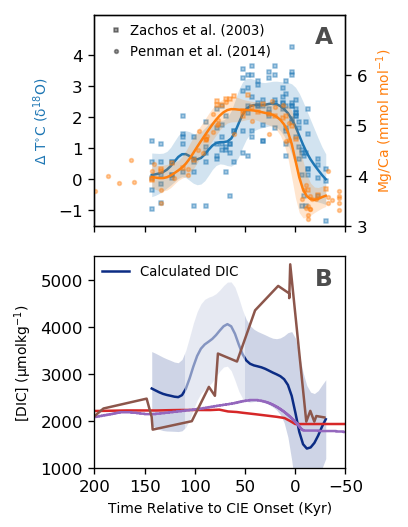

In [112]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=[3.5, 4.5], sharex=True)

labels = 'ABCDE'

ax1.scatter(zx, zy.values - temp18O['mean'][0], s=5, alpha=0.4, c='C0', marker='s')
ax1.plot(zxnew, temp18O['delta'], c='C0')
ax1.fill_between(zxnew, 
                 temp18O['delta'] - temp18O['std'], 
                 temp18O['delta'] + temp18O['std'], alpha=0.2, color='C0', lw=0)

ax1a = ax1.twinx()
ax1a.scatter(ozmgx, ozmgy, s=5, alpha=0.4, c='C1', marker='s')
ax1a.scatter(pzmgx, pzmgy, s=5, alpha=0.4, c='C1')
ax1a.plot(zxnew, zMgCa['mean'], c='C1')
ax1a.fill_between(zxnew, 
                  zMgCa['mean'] - zMgCa['std'], 
                  zMgCa['mean'] + zMgCa['std'], alpha=0.2, color='C1', lw=0)

ax1.set_ylim(-1.5, 5.3)
ax1.set_yticks([-1, 0, 1, 2, 3, 4])
ax1.set_ylabel('$\Delta\ T^{\circ}C\ (\delta^{18}O)$', color='C0')
ax1a.set_ylim(3, 7.2)
ax1a.set_yticks([3, 4, 5, 6])
ax1a.set_ylabel('Mg/Ca (mmol $mol^{-1}$)', color='C1')

ax2.plot(zxnew, nom(petm_DIC), c='#0c2c84', zorder=-3)
ax2.fill_between(zxnew, 
                 nom(petm_DIC) - err(petm_DIC), 
                 nom(petm_DIC) + err(petm_DIC),
                 alpha=0.2, color='#0c2c84', lw=0, zorder=-4)
ax2.plot(petm_DIC_LOSCAR.Time_WRT_CIE, petm_DIC_LOSCAR.DIC * 1e6, label='_Zeebe et al. (2009)', c='C3')
ax2.plot(petm_DIC_Gutjahr.Time_WRT_CIE, petm_DIC_Gutjahr.DIC * 1e6, label='_Gutjahr et al. (2017)', c='C4')
ax2.plot(petm_DIC_Haynes.Time_WRT_CIE, petm_DIC_Haynes.DIC * 1e6, label='_Haynes et al. (2017)', c='C5')

ax2.set_ylim(1000, 5500)
ax2.set_ylabel('[DIC] ($\mu mol kg^{-1}$)')
ax2.set_yticks([1000, 2000, 3000, 4000, 5000])
ax2.set_xlim(200, -50)

ax2.set_xlabel('Time Relative to CIE Onset (Kyr)')

ax1.scatter([], [], marker='s', s=5, label='Zachos et al. (2003)', c='k', alpha=0.4)
ax1.scatter([], [], s=5, label='Penman et al. (2014)', c='k', alpha=0.4)
ax1.legend(loc='upper left', fontsize=8, handletextpad=0.1,  framealpha=0, borderpad=0.1)

ax2.plot([], [], label='Calculated DIC', c='#0c2c84')
ax2.legend(loc='upper left', fontsize=8,  framealpha=0, borderpad=0.1)

for i, ax in enumerate([ax1, ax2]):
    ax.text(.95, .95, labels[i], ha='right', va='top', transform=ax.transAxes, weight='bold',
            fontsize=14, color=(.3, .3, .3), zorder=2)

ax2.axvspan(110, 50, color=(1,1,1,0.5), zorder=-2, lw=0)

fig.tight_layout()

fig.savefig('Plots/09_PETM_DIC.pdf')

In [113]:
# first excursion
petm_DIC[(zxnew > 10) & (zxnew < 30)].mean() - un.nominal_value(petm_DIC[0])

970.1705244093846+/-494.0403321285726

In [114]:
# second excursion
petm_DIC[(zxnew > 60) & (zxnew < 120)].max() - petm_DIC[(zxnew > 10) & (zxnew < 30)].mean()

1053.5619446682767+/-779.651234117081

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

##  9. Hans G.rubers<a id='Gruber'></a>

    You ask for a miracle?
    
Can our model explain Mg/Ca in other species?

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 9.1 Load *G. ruber* data <a id='Gruber_load'></a>

In [115]:
rd = load.mg_data('Data/Compiled_Mg_Data.xlsx', species='ruber')

rd = load.calc_myami_Csys(rd)
rd.loc[:, 'DMg'] = rd.loc[:, 'Mg/Caf'] / rd.loc[:, 'Mg/Casw']

# rd = rd.loc[rd.Salinity < 40]

gray = pd.read_table('Data/Gray_2018_Gruber.tab', skiprows=66)

rrdict = {
          'Evans': "Evans et al. (2016)",
          'Henehan': "Henehan et al. (2013)",
          'Kısakürek': "Kısakürek et al. (2008)",
          'Allen': "Allen et al. (2016)",
          'Hönisch': "Hönisch et al. (2013)",
          'Haynes (subm)': "Haynes et al. (subm)",
         }

rmdict = {
    'Haynes (subm)': '^',
    'Hönisch': 'v',
    'Allen': 's',
    'Evans': 'o',
    'Henehan': 'd',
    'Kısakürek': 'D',
          }

tstyle = {
    'white': {'color': 'w', 'edgecolor': 'k', 'lw': 0.5},
    'pink': {'color': (1,.8,.8), 'edgecolor': 'k', 'lw': 0.5}    
}

Calculating MyAMI Constants: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


In [116]:
[print(r + '\n') for r in rd.Reference.unique()]

Evans, D., B. S. Wade, M. Henehan, J. Erez, and W. Muller. "Revisiting carbonate chemistry controls on planktic foraminifera Mg/Ca: implications for sea surface temperature and hydrology shifts over the Paleocene–Eocene Thermal Maximum and Eocene–Oligocene Transition." Climate of the Past 11 (2015): 3143-3185.

Henehan, Michael J., James WB Rae, Gavin L. Foster, Jonathan Erez, Katherine C. Prentice, Michal Kucera, Helen C. Bostock et al. "Calibration of the boron isotope proxy in the planktonic foraminifera Globigerinoides ruber for use in palaeo-CO 2 reconstruction." Earth and Planetary Science Letters 364 (2013): 111-122.

Kısakürek, B., Anton Eisenhauer, Florian Böhm, D. Garbe-Schönberg, and J. Erez. "Controls on shell Mg/Ca and Sr/Ca in cultured planktonic foraminiferan, Globigerinoides ruber (white)." Earth and Planetary Science Letters 273, no. 3 (2008): 260-269.

Allen, Katherine A., Bärbel Hönisch, Stephen M. Eggins, Laura L. Haynes, Yair Rosenthal, and Jimin Yu. "Trace element

[None, None, None, None, None]

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 9.2 View Parameter Space <a id='Gruber_paramspace'></a>

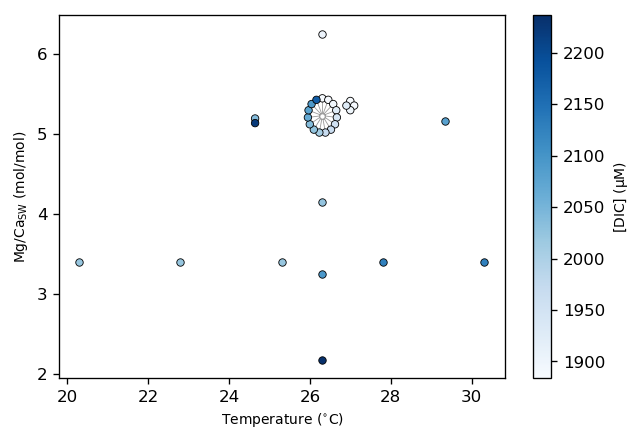

In [117]:
fig, ax = plt.subplots(1,1)

x_thresh = [19, 21, 23, 25.5, 27, 29, 33]
y_thresh = [1.8, 2.5, 4, 5, 6, 8]

xt_last = 0
yt_last = 0

cvar = 'DIC'

vmin = rd.loc[:, cvar].min()
vmax = rd.loc[:, cvar].max()

for xt in x_thresh:
    for yt in y_thresh:
        ind = ((rd.loc[:,'Temp'] >= xt_last) & (rd.loc[:,'Temp'] <= xt) &
               (rd.loc[:,'Mg/Casw'] >= yt_last) & (rd.loc[:,'Mg/Casw'] <= yt))
        if sum(ind) > 0:
            x, y, xm, ym = plot.spreadm(rd.loc[ind,'Temp'].astype(float).values,
                                        rd.loc[ind,'Mg/Casw'].astype(float).values,
                                        x_tol=0.2, y_tol=0.12, offset_mult=0.12)

            if xm is not None:
                for xi, yi in zip(x,y):
                    c = (.6, .6, .6)
                    ax.plot([xm, xi], [ym, yi], lw=0.5, c=c, zorder=-1)
                    ax.scatter(xm, ym, c='w', edgecolor=c, lw=0.5, s=10)

            ma = ax.scatter(x, y, c=sorted(rd.loc[ind, cvar]), vmin=vmin, vmax=vmax, cmap=plt.cm.Blues, s=20, lw=0.5, edgecolor='k')       
        
        yt_last = yt
    xt_last = xt

ax.set_xlabel('Temperature ($^{\circ}C$)')
ax.set_ylabel('Mg/Ca$_{SW}$ (mol/mol)')
    
fig.colorbar(ma, label='[DIC] ($\mu M$)')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 9.3 pH/CO3 system in G. ruber data <a id='Gruber_CO3pH'></a>

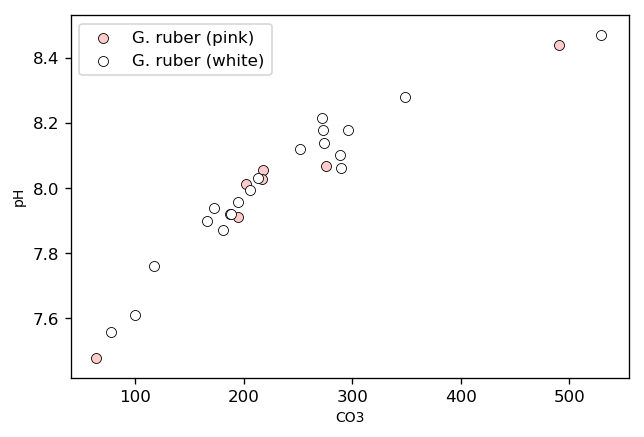

In [118]:
for t in ['pink', 'white']:
    plt.scatter(rd.loc[rd.Type == t, 'CO3'], rd.loc[rd.Type == t, 'pHtot'], **tstyle[t], label='G. ruber ({})'.format(t))
    plt.ylabel('pH')
    plt.xlabel('CO3')

plt.legend()

**Note:** In all *G. ruber* studies to date, CO3 and pH co-vary. It is therefore impossible to deconvolve the influence of these two parameters.

In the workings below, we use CO3, but this could be equivalently be replaced with [H<sup>+</sup>] or pH.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 9.4 Fit cultured *G. ruber* data. <a id='Gruber_fit'></a>

We treat white and pink variants independently.

In [119]:
# define fitting function
def mgca_fn(x, A, B, C1, C2, D):
    MgCa, Ca, C, T = x
    return MgCa**A * B * np.exp((C1 * Ca + C2 * C + D) * T)

# version for uncertainty propagation
def umgca_fn(x, A, B, C1, C2, D):
    MgCa, Ca, C, T = x
    return MgCa**A * B * un.unumpy.exp((C1 * Ca + C2 * C + D) * T)

def mgca_fn_pink(x, pre_exp, C1, C2, D):
    MgCa, Ca, C, T = x
    return pre_exp * np.exp((C1 * Ca + C2 * C + D) * T)

def umgca_fn_pink(x, pre_exp, C1, C2, D):
    MgCa, Ca, C, T = x
    return pre_exp * un.unumpy.exp((C1 * Ca + C2 * C + D) * T)

p0 = (1.5, 0.05, 6.5, -30, 0.01)


rpar = {}
rpred = {}

# G ruber white
t = 'white'
sub = rd.loc[rd.Type == t]

for cvar in ['', '_pH']:
    # package data for fitting
    if cvar == '_pH':
        x = (sub.loc[:, 'Mg/Casw'].astype(float),  # molar ratio (unitless)
             sub.loc[:, '[Ca]sw'].values * 1e-3,  # molar
             10**-sub.loc[:, 'pHtot'].values,
             sub.loc[:, 'Temp'].values)  # celcius
    else:
        x = (sub.loc[:, 'Mg/Casw'].astype(float),  # molar ratio (unitless)
             sub.loc[:, '[Ca]sw'].values * 1e-3,  # molar
             sub.loc[:, 'CO3'].values * 1e-6,  # molar
             sub.loc[:, 'Temp'].values)  # celcius


    # fit model
    pe, cov = curve_fit(mgca_fn, x, sub.loc[:, 'Mg/Caf'], (1, 1, 0, 0, 0))#, sigma=rd.loc[:, 'Mg/Caf 2se'], maxfev=4000)
    rpar[t + cvar] = un.correlated_values(pe, cov)
    rpred[t + cvar] = umgca_fn(x, *rpar[t + cvar])
    
# DIC fit to white
t = 'white'
sub = rd.loc[rd.Type == t]

# package eda for fitting
x = (sub.loc[:, 'Mg/Casw'].astype(float),  # molar ratio (unitless)
     sub.loc[:, '[Ca]sw'].values * 1e-3,  # molar
     sub.loc[:, 'DIC'].values * 1e-6,  # molar
     sub.loc[:, 'Temp'].values)  # celcius

# fit model
pe, cov = curve_fit(mgca_fn, x, sub.loc[:, 'Mg/Caf'])#, sigma=rd.loc[:, 'Mg/Caf 2se'], maxfev=4000)

rpar[t + '_DIC'] = un.correlated_values(pe, cov)
rpred[t + '_DIC'] = umgca_fn(x, *rpar[t + '_DIC'])

# G ruber pink (no Mg or Ca variation)

t = 'pink'
sub = rd.loc[rd.Type == t]

for cvar in ['', '_pH']:
    # package data for fitting
    if cvar == '_pH':
        x = (sub.loc[:, 'Mg/Casw'].astype(float).values,  # molar ratio (unitless)
             sub.loc[:, '[Ca]sw'].values * 1e-3,  # molar
             10**-sub.loc[:, 'pHtot'].values,
             sub.loc[:, 'Temp'].values)  # celcius
    else:
        x = (sub.loc[:, 'Mg/Casw'].astype(float).values,  # molar ratio (unitless)
             sub.loc[:, '[Ca]sw'].values * 1e-3,  # molar
             sub.loc[:, 'CO3'].values * 1e-6,  # molar
             sub.loc[:, 'Temp'].values)  # celcius
    
    # fit model
    pe, cov = curve_fit(mgca_fn_pink, x, sub.loc[:, 'Mg/Caf'], (1, 0, 0, 0))#, sigma=rd.loc[:, 'Mg/Caf 2se'], maxfev=4000)
    
#     print(t + cvar)
    rpar[t + cvar] = un.correlated_values(pe, cov)
    rpred[t + cvar] = umgca_fn_pink(x, *rpar[t + cvar])

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 9.5 Fit Sediment-Trap *G. ruber* data <a id='Gruber_sed_fit'></a>

In [120]:
# Gray's Data
Mgsw = 52.8
Casw = 10.28

gray.loc[:, 'Mg'] = Mgsw * gray.loc[:, 'Sal'] / 35
gray.loc[:, 'Ca'] = Casw * gray.loc[:, 'Sal'] / 35
gray.loc[:, 'MgCa'] = gray.loc[:, 'Mg'] / gray.loc[:, 'Ca']

x = (
     gray.loc[:, 'MgCa'].values, 
     gray.loc[:, 'Ca'].values * 1e-3, 
     gray.loc[:, '[CO3]2- [µmol/kg]'].values * 1e-6, 
     gray.loc[:, 'Temp [°C]'].values
)

def mgca_fn_gray(x, C1, C2, D):
    A, B = 0.831, 0.165
    return mgca_fn(x, A, B, C1, C2, D)

p, cov = curve_fit(mgca_fn_gray, x, gray.loc[:, 'G. ruber w Mg/Ca [mmol/mol]'].values, 
                   nom(rpar['white'][-3:]))

gcov = np.asanyarray(un.covariance_matrix(rpar['white']).copy())
gcov[2:, 2:] = cov
gp = nom(rpar['white']).copy()
gp[2:] = p

rpar['gray'] = un.correlated_values(gp, gcov)
rpred['gray'] = umgca_fn(x, *rpar['gray'])

# pH fit
x = (
     gray.loc[:, 'MgCa'].values, 
     gray.loc[:, 'Ca'].values * 1e-3, 
     10**-gray.loc[:, 'pH'].values, 
     gray.loc[:, 'Temp [°C]'].values
)

p, cov = curve_fit(mgca_fn_gray, x, gray.loc[:, 'G. ruber w Mg/Ca [mmol/mol]'].values, 
                   (0,0,0.1))

gcov = np.asanyarray(un.covariance_matrix(rpar['white']).copy())
gcov[2:, 2:] = cov
gp = nom(rpar['white']).copy()
gp[2:] = p

rpar['gray_pH'] = un.correlated_values(gp, gcov)
rpred['gray_pH'] = umgca_fn(x, *rpar['gray_pH'])

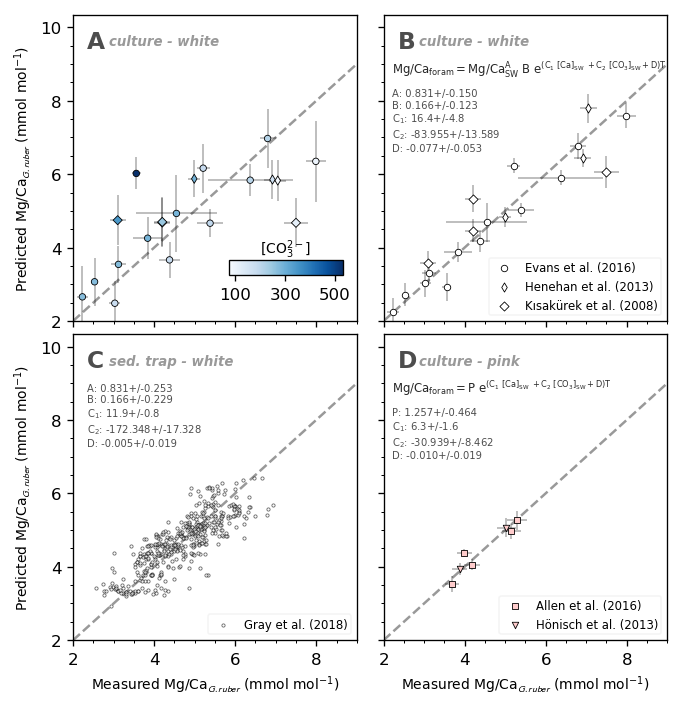

In [121]:
fig, axs = figures.fig5(rd, gray, rmdict, rrdict, rpred, rpar, tstyle)

fig.savefig('Plots/05_Gruber.pdf')

#### Plot with pH

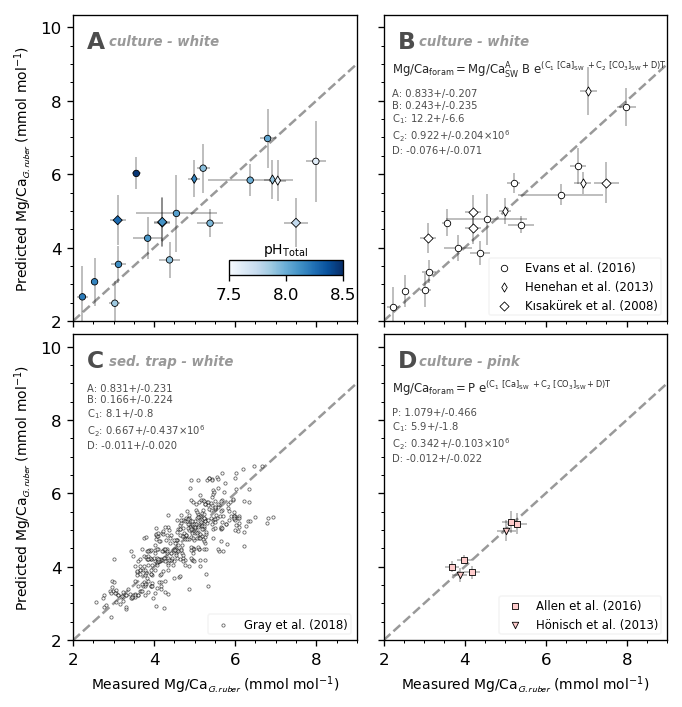

In [122]:
fix, axs = figures.fig5_pH(rd, gray, rmdict, rrdict, rpred, rpar, tstyle)

fig.savefig('Plots/05_Gruber_H.pdf')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 9.6 Model-Data Residual Patterns <a id='Gruber_resids'></a>

#### Culture Data

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


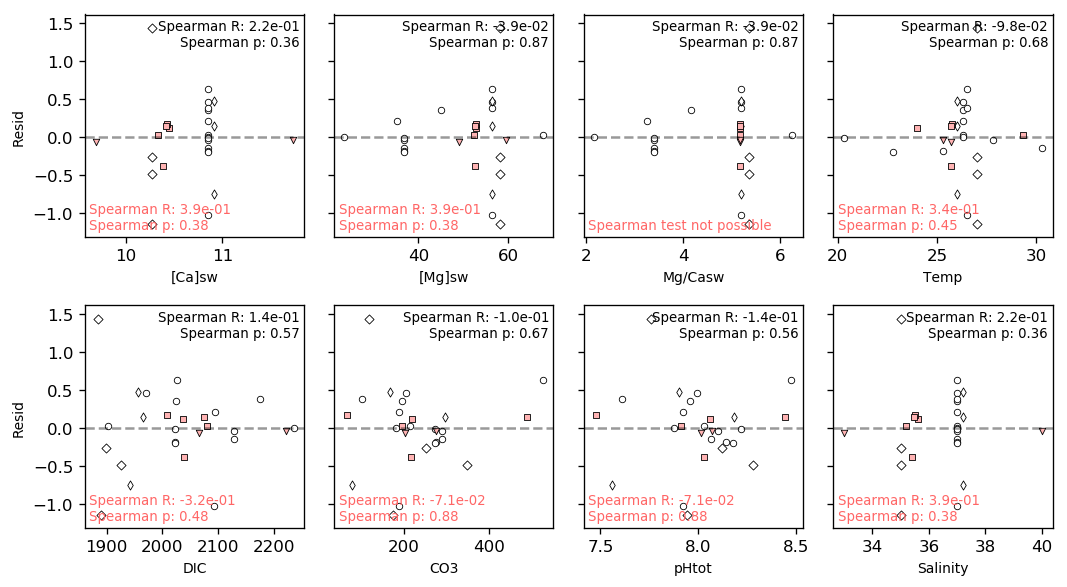

In [123]:
vari = ('[Ca]sw',
        '[Mg]sw',
        'Mg/Casw',
        'Temp',
        'DIC',
        'CO3',
        'pHtot',
        'Salinity')

fig, axs = plt.subplots(2, 4, figsize=(9, 5), sharey=True)

for v, ax in zip(vari, axs.flatten()):

    for t in rd.Type.unique():
        d = rd.loc[rd.Type == t]
        pred = rpred[t]
        
        resid = nom(d.loc[:, 'Mg/Caf'] - pred)
        
        if t == 'white':
            c = 'w'
            tc='k'
            loc = {'x': 0.98, 'y': 0.98, 'ha': 'right', 'va': 'top'}
        else:
            c = (1,.7,.7)
            tc = (1,.4,.4)
            loc = {'x': 0.02, 'y': 0.02, 'ha': 'left', 'va': 'bottom'}
            
        for w in rd.who.unique():
            ax.scatter(d.loc[d.who == w, v], resid[d.who == w], color=c,
                       marker=rmdict[w], label=rrdict[w], s=15, edgecolor='k', lw=0.5)
    
        nancatch = ~(np.isnan(d.loc[:, v]) | np.isnan(resid))
        R, sp = stats.spearmanr(d.loc[nancatch, v], resid[nancatch])
        if not np.isnan(R):
            if sp < 0.01:
                spt = '< 0.01'
            else:
                spt = '{:.2f}'.format(sp)
            stat_text = 'Spearman R: {:.1e}\nSpearman p: {}'.format(R, spt)
        else:
            stat_text = "Spearman test not possible"
        ax.text(**loc, s=stat_text, transform=ax.transAxes, fontsize=8, color=tc)
    
    ax.set_xlabel(v)
    if ax.is_first_col():
        ax.set_ylabel('Resid')

    ax.axhline(0, ls='dashed', color=(0,0,0,0.4))

fig.tight_layout()

fig.savefig('Plots/S_ruber_resids.pdf')

#### Sed Trap Data

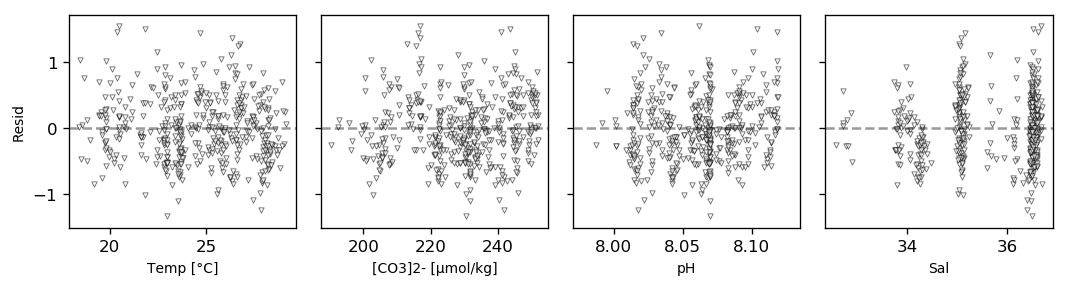

In [124]:
vari = ('Temp [°C]',
        '[CO3]2- [µmol/kg]',
        'pH',
        'Sal')

fig, axs = plt.subplots(1, 4, figsize=(9, 2.5), sharey=True)

for v, ax in zip(vari, axs.flatten()):
    
    if v == '':
        ax.set_visible(False)
        continue

    d = gray
    pred = rpred['gray']

    resid = nom(d.loc[:, 'G. ruber w Mg/Ca [mmol/mol]'] - pred)

    if t == 'white':
        c = 'w'
    else:
        c = (1,.7,.7)

    ax.scatter(d.loc[:, v], resid, color='w',
               marker=rmdict[w], label=rrdict[w], s=10, edgecolor='k', lw=0.5, alpha=0.6)
        
    ax.set_xlabel(v)
    if ax.is_first_col():
        ax.set_ylabel('Resid')

    ax.axhline(0, ls='dashed', color=(0,0,0,0.4))

fig.tight_layout()

fig.savefig('Plots/S_ruber_resids.pdf')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 9.7 *G. ruber* (white) model skill comparison <a id='Gruber_skill'></a>

In [125]:
# fit different models
rd_white = rd.loc[rd.Type == 'white']

# exponential
exp_p, _ = curve_fit(exponential, rd_white.loc[:, 'Temp'], 
                     rd_white.loc[:, 'Mg/Caf'])#, sigma=rd_white.loc[:, 'Mg/Caf 2se'])
exp_pred = exponential(rd_white.loc[:, 'Temp'], *exp_p)

# Evans 2012
e2012_p, _ = curve_fit(evans2012, (rd_white.loc[:, 'Temp'], rd_white.loc[:, 'Mg/Casw']),
                       rd_white.loc[:, 'Mg/Caf'])#, sigma=rd_white.loc[:, 'Mg/Caf 2se'])
e2012_pred = evans2012((rd_white.loc[:, 'Temp'], rd_white.loc[:, 'Mg/Casw']), *e2012_p)

# Evans 2015
e2015_p, _ = curve_fit(evans2015, (rd_white.loc[:, 'Temp'], rd_white.loc[:, 'Mg/Casw']),
                       rd_white.loc[:, 'Mg/Caf'])#, sigma=rd_white.loc[:, 'Mg/Caf 2se'])
e2015_pred = evans2015((rd_white.loc[:, 'Temp'], rd_white.loc[:, 'Mg/Casw']), *e2015_p)

# package data for fitting
x = (rd_white.loc[:, 'Mg/Casw'].astype(float),  # molar ratio (unitless)
     rd_white.loc[:, '[Ca]sw'].values * 1e-3,  # molar
     rd_white.loc[:, 'CO3'].values * 1e-6,  # molar
     rd_white.loc[:, 'Temp'].values)  # celcius

# fit model
p, cov = curve_fit(mgca_fn, x, rd_white.loc[:, 'Mg/Caf'], p0=p0) # , sigma=rd_white.loc[:, 'Mg/Caf 2se'])

pred = mgca_fn(x, *p)

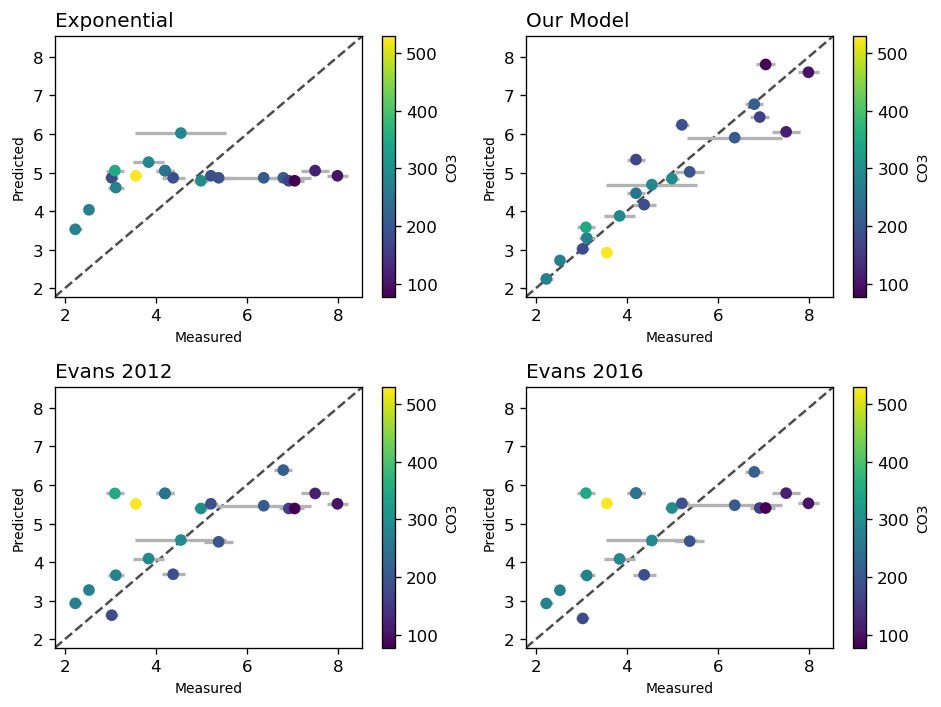

In [126]:
fig, axs = plt.subplots(2, 2, figsize=[8, 6])

# exponential
axs[0,0].set_title('Exponential', loc='left')
cvar = 'CO3'
plot.compare(obs=rd_white.loc[:, 'Mg/Caf'], 
             pred=exp_pred,
             errs=rd_white.loc[:, 'Mg/Caf 2se'],
             c=rd_white.loc[:, cvar], clab=cvar, 
             figax=(fig, axs[0,0]))

# our model
axs[0, 1].set_title('Our Model', loc='left')
# cvar = 'pHtot'
plot.compare(obs=rd_white.loc[:, 'Mg/Caf'], 
             pred=nom(rpred['white']),
             errs=rd_white.loc[:, 'Mg/Caf 2se'],
             c=rd_white.loc[:, cvar], clab=cvar, 
             figax=(fig, axs[0,1]))

# evans 2012
axs[1, 0].set_title('Evans 2012', loc='left')
# cvar = 'pHtot'
plot.compare(obs=rd_white.loc[:, 'Mg/Caf'], 
             pred=e2012_pred,
             errs=rd_white.loc[:, 'Mg/Caf 2se'],
             c=rd_white.loc[:, cvar], clab=cvar, 
             figax=(fig, axs[1, 0]))

# evans 2016
axs[1, 1].set_title('Evans 2016', loc='left')
# cvar = 'pHtot'
plot.compare(obs=rd_white.loc[:, 'Mg/Caf'], 
             pred=e2015_pred,
             errs=rd_white.loc[:, 'Mg/Caf 2se'],
             c=rd_white.loc[:, cvar], clab=cvar, 
             figax=(fig, axs[1, 1]))

fig.tight_layout()

# fig.savefig('Plots/model_comparison.pdf')

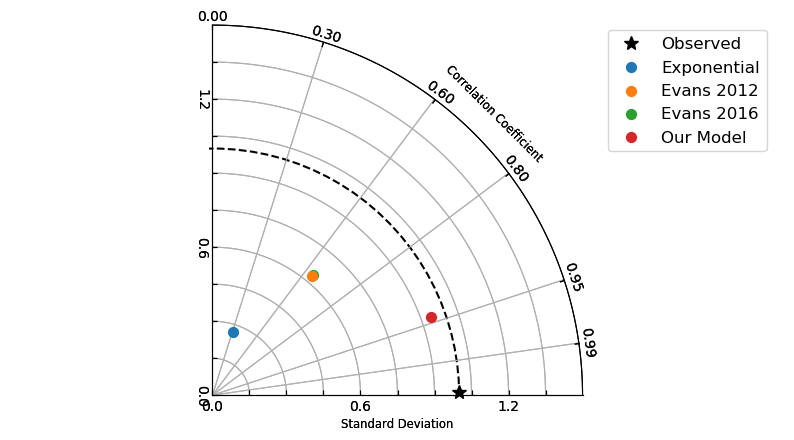

In [127]:
fig, ax = taylor_diag.Taylor_diag({0: rd_white.loc[:, 'Mg/Caf'] * 1e3,
                                   'Exponential': exp_pred * 1e3,
                                   'Evans 2012': e2012_pred * 1e3,
                                   'Evans 2016': e2015_pred * 1e3,
                                   'Our Model': nom(rpred['white']) * 1e3})

Our model offers a significant improvement in skill over previously proposed forms.